Load the environmental data from various places.
Remove missing data and convert variables to the appropriate types

In [1]:
# Probe & USGS Discharge Data
env_data_dir = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/environmental_raw_data"
env_data_file1 = paste(env_data_dir, "Transformed_WQVars_Hab_and_aDiv.txt", sep="/")
env_data_file1.2 = paste(env_data_dir, "Transformed_WQ_Vars_and_Habitats_Final.txt", sep="/")
env_data_1.2 <- read.delim(env_data_file1.2, row.names=1)[,'HABITAT.2']
env_data_file2 = paste(env_data_dir, "merged_paired_water_quality_data.txt", sep="/")
env_data_1 <- cbind.data.frame(read.delim(env_data_file1, row.names=1), env_data_1.2)
colnames(env_data_1)[colnames(env_data_1) == 'env_data_1.2'] = 'HABITAT.2'
env_data_orig <- read.delim(env_data_file2, row.names=1)

extra_cols1 = c('ENSpie.1', 'FaithsPD.1', 'Observed.ASVs.1', 'Chao1', 'ACE',  'Observed.ASVs', 'qPCR.ct', 
                'Discharge_Susquehanna.15', 'SpringPeak', 'Station', 'ENSpie')

ENV.mini = env_data_1[,colnames(env_data_1)[which(!(colnames(env_data_1) %in% extra_cols1))]]

ENV.mini$Microbial.Clusters <- factor(ENV.mini$Microbial.Clusters)
ENV.mini$WaterColumnPosition <- factor(ENV.mini$WaterColumnPosition)
intcols = colnames(ENV.mini)[which(sapply(ENV.mini, class) == 'integer')]
for (ic in intcols)
    ENV.mini[,ic] = factor(ENV.mini[,ic])

ENV.mini[,'Habitat'] <- NULL
names(ENV.mini)[names(ENV.mini) == 'HABITAT.2'] = 'Habitat'
#ENV.mini = ENV.mini[,which(colSums(is.na(ENV.mini)) == 0)]
sapply(ENV.mini, class)
sum(colSums(is.na(ENV.mini)))
table(ENV.mini$WaterColumnPosition, ENV.mini$Habitat)

PHEO                  TN                  TP                CHLA 
          "numeric"           "numeric"           "numeric"           "numeric" 
                DOP                 DON                NH4F                NO2F 
          "numeric"           "numeric"           "numeric"           "numeric" 
               NO3F                  PC                PO4F                  DO 
          "numeric"           "numeric"           "numeric"           "numeric" 
                 PH            SALINITY               WTEMP            Latitude 
          "numeric"           "numeric"           "numeric"           "numeric" 
  WIND_RATIO_BWI.15   WIND_RATIO_BWI.30   WIND_RATIO_BWI.60   PRECIP24HR_BWI.15 
          "numeric"           "numeric"           "numeric"           "numeric" 
  PRECIP24HR_BWI.30   PRECIP24HR_BWI.60  measurement_PAR.15  measurement_PAR.30 
          "numeric"           "numeric"           "numeric"           "numeric" 
 measurement_PAR.60 WaterColumnPosition           cruise_id          SampleDate 
          "numeric"            "factor"            "factor"         "character" 
         LinearTime           DayLength            FallPeak    Discharge_Sum.15 
          "numeric"           "numeric"           "numeric"           "numeric" 
 Microbial.Clusters            StatName          InvSimpson            FaithsPD 
           "factor"            "factor"           "numeric"           "numeric" 
            Habitat 
           "factor"

[1] 0

       
         1  2  3
  lower 94 64 17
  upper  0  0 61

Read in the taxa classfications and tree

In [2]:
mean(ENV.mini[which(ENV.mini[,'Microbial.Clusters'] == 'M.1'), 'DO'], na.rm=TRUE)
mean(ENV.mini[which(ENV.mini[,'Microbial.Clusters'] == 'M.2'), 'DO'], na.rm=TRUE)
mean(ENV.mini[which(ENV.mini[,'Microbial.Clusters'] == 'M.3'), 'DO'], na.rm=TRUE)
table(ENV.mini$Microbial.Clusters, ENV.mini$Habitat)

[1] 0.507568

[1] 0.5459919

[1] -0.7276199

     
       1  2  3
  M.1 19 10 43
  M.2 19 12 34
  M.3 56 42  1

In [3]:
library(phyloseq)
#Taxonomy of each OTU
tax = read.delim("/Volumes/KeithSSD/ChesapeakeMicrobiome/data/otu_tables/taxa_table_with_OTUs.txt", row.names=1)
tax_mat = as.matrix(tax)
colnames(tax_mat)[1] <- 'Domain'
tax_mat[tax_mat == ""] <- NA

#Tree of all otus
tree_file = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/phylogenetic_tree/RAxML_rootedTree.root.query_all_abund.2.ref.tre"
tree_obj = read_tree(tree_file, errorIfNULL=T)

Replace zeroes with pseudocounts and transform with phylogenetically aware ILR

In [4]:
library(philr) 
library(ape) 
library(ggplot2)
library(zCompositions)

#OTU table (shared file)
OTU2 = read.delim("../data/otu_tables/final_rarefied_table.best.txt", row.names=1)
OTU.clean2 = OTU2[rownames(ENV.mini), ]
OTU.clean2.1 = as.matrix(OTU.clean2[,colSums(OTU.clean2) > 0])
OTU.clean2.2 <- data.matrix(OTU.clean2.1 + 0.5) #cmultRepl((OTU.clean2.1), method="CZM", output="p-counts"))
tax.clean2 = tax_mat[colnames(OTU.clean2.2), ]
tree.clean2 = prune_taxa(taxa=colnames(OTU.clean2.2), tree_obj)
dim(OTU.clean2.2)
dim(tax.clean2)
is.rooted(tree.clean2)
is.binary.tree(tree.clean2) 
tree.clean2.1 <- makeNodeLabel(tree.clean2, method="number", prefix='n')
name.balance(tree.clean2.1, tax.clean2, 'n1')

physeq_2 = phyloseq(otu_table(OTU.clean2.2, taxa_are_rows = FALSE), 
                    tax_table(tax.clean2), sample_data(ENV.mini), tree.clean2.1)

gp.philr <- philr(OTU.clean2.2, tree.clean2.1, part.weights='enorm.x.gm.counts',  ilr.weights='blw.sqrt')
gp.dist <- dist(gp.philr, method="euclidean")

Registered S3 method overwritten by 'treeio':
  method     from
  root.phylo ape 

Loading required package: MASS

Loading required package: NADA

Loading required package: survival


Attaching package: ‘NADA’


The following object is masked from ‘package:stats’:

    cor


Loading required package: truncnorm



[1]  236 1349

[1] 1349    7

[1] TRUE

[1] TRUE

[1] "Domain_Bacteria/Domain_Bacteria"

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘tidytree’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘tidytree’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘tidytree’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘tidytree’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘tidytree’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘tidytree’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘tidytree’

Building Sequential Binary Partition from Tree...

Building Contrast Matrix...

Transforming the Data...

Calculating ILR Weights...



Perform PCoA, determine the best cluster number, perform clustering, check accuracy

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:survival’:

    cluster


Loading required package: permute

This is vegan 2.5-7


Attaching package: ‘vegan’


The following object is masked from ‘package:caret’:

    tolerance




*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


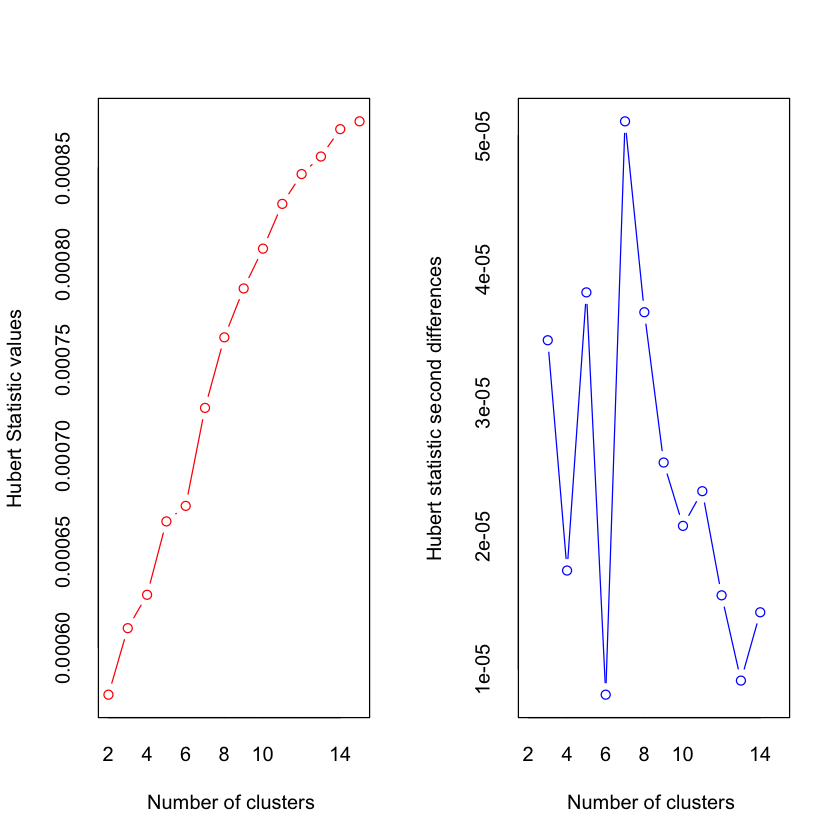

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 6 proposed 2 as the best number of clusters 
* 6 proposed 3 as the best number of clusters 
* 1 proposed 4 as the best number of clusters 
* 4 proposed 5 as the best number of clusters 
* 1 proposed 6 as the best number of clusters 
* 1 proposed 11 as the best number of clusters 
* 1 proposed 13 as the best number of clusters 
* 3 proposed 15 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  2 
 
 
**************************

       
pam.res  1  2  3
      1 54  0 17
      2 26 61 27
      3 14  3 34

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3
         1 54  0 17
         2 26 61 27
         3 14  3 34

Overall Statistics
                                         
               Accuracy : 0.6314         
                 95% CI : (0.5663, 0.693)
    No Information Rate : 0.3983         
    P-Value [Acc > NIR] : 4.367e-13      
                                         
                  Kappa : 0.4561         
                                         
 Mcnemar's Test P-Value : 7.279e-10      

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.5745   0.9531   0.4359
Specificity            0.8803   0.6919   0.8924
Pos Pred Value         0.7606   0.5351   0.6667
Neg Pred Value         0.7576   0.9754   0.7622
Prevalence             0.3983   0.2712   0.3305
Detection Rate         0.2288   0.2585   0.1441
Detection Prevalence   0.3008   0.4831   0.2161
Balanced Accuracy      0.7274   0.8225   0.6642

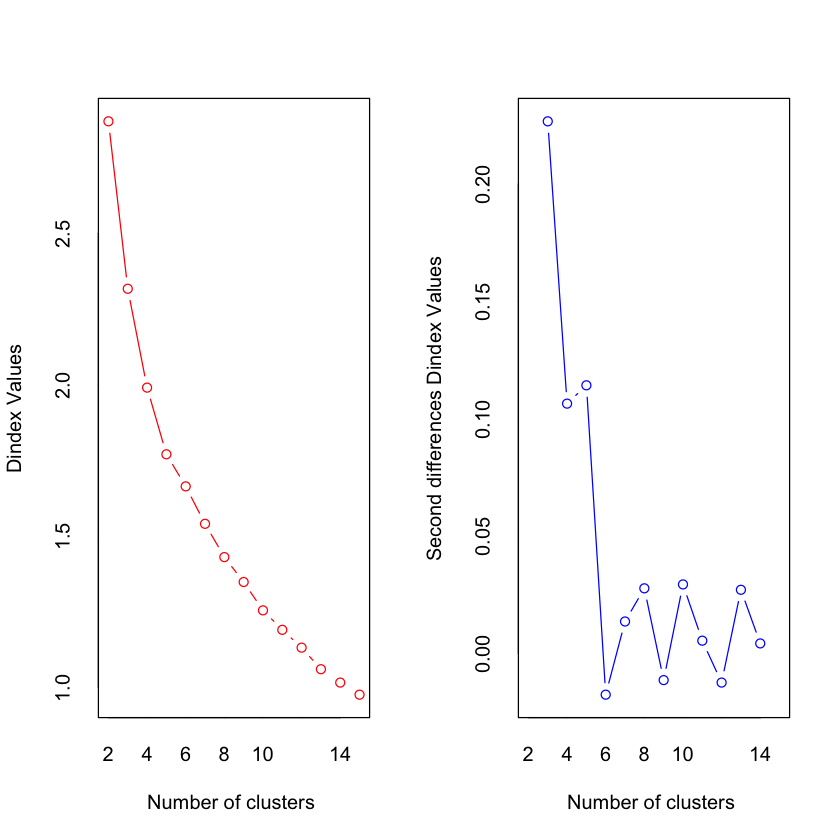

In [5]:
library(caret)
library(vegan)
library(cluster)
gp.pcoa <- ordinate(physeq_2, 'PCoA', distance=gp.dist)
DCAxyz = gp.pcoa$vectors[,1:3]
library(NbClust)
number <- suppressMessages(NbClust(DCAxyz, distance="euclidean", min.nc=2, max.nc=15, method='ward.D2', index='all'))
print(colnames(number[['Best.nc']])[which(number[['Best.nc']]['Number_clusters',]  == 3.)])
pam.res <- pam(DCAxyz, 3, diss=FALSE, metric='euclidean')$clustering
table(pam.res, ENV.mini$Habitat)
ENV.mini$Microbial.Clusters = factor(paste("M", pam.res, sep='.'), levels=c('M.1', 'M.2', 'M.3'))

confusionMatrix(factor(as.integer(ENV.mini$Microbial.Clusters)), 
                factor(ENV.mini$Habitat))


In [6]:
library(stringr)
#just_clusters = ENV.mini[,c("Habitat", 'Microbial.Clusters')]
#write.table(just_clusters, file='/Volumes/KeithSSD/ChesapeakeMicrobiome/data/environmental_raw_data/both_cluster_types.txt',
#           sep="\t", row.names=T)



mean(ENV.mini[which(ENV.mini[,'Microbial.Clusters'] == 'M.1'), 'DO'])
mean(ENV.mini[which(ENV.mini[,'Microbial.Clusters'] == 'M.2'), 'DO'])
mean(ENV.mini[which(ENV.mini[,'Microbial.Clusters'] == 'M.3'), 'DO'])

mc_ = factor(str_split_fixed(ENV.mini[,'Microbial.Clusters'], "", 3)[,3])
table(mc_, ENV.mini[,'Habitat'])



[1] -0.4507431

[1] -0.04931277

[1] 0.7377336

   
mc_  1  2  3
  1 54  0 17
  2 26 61 27
  3 14  3 34

In [7]:
ENV.mini.2 <- subset(ENV.mini, select=-c(SampleDate, FaithsPD, InvSimpson, Microbial.Clusters))


cap.env.mini <- capscale(gp.dist ~ ., data=ENV.mini.2)
mod0.env.mini <- capscale(gp.dist ~ 1, data=ENV.mini.2)
#step.env.mini <- ordistep(mod0.env.mini, scope=formula(cap.env.mini), direction ="both", trace=T)

In [8]:
ENV.mini.2.nohab <- subset(ENV.mini.2, select=-c(cruise_id, Habitat, StatName))
cap.env.mini.u <- capscale(gp.dist ~ ., data=ENV.mini.2.nohab)
mod0.env.mini.u <- capscale(gp.dist ~ 1, data=ENV.mini.2.nohab)
#step.env.mini.u <- ordiR2step(mod0.env.mini.u, scope=formula(cap.env.mini.u), direction ="both", trace=T)

In [9]:
RsquareAdj(capscale(gp.dist ~ cruise_id + StatName + Habitat, data=ENV.mini.2))
RsquareAdj(capscale(gp.dist ~ FallPeak + SALINITY + DayLength + PO4F + LinearTime, data=ENV.mini.2))

$r.squared
[1] 0.6389872

$adj.r.squared
[1] 0.6090415

$r.squared
[1] 0.5222284

$adj.r.squared
[1] 0.5118421

In [10]:
model_types = list('categorical' = c('cruise_id', 'StatName', 'Habitat'),
                   'continuous' = c('FallPeak', 'SALINITY', 'DayLength', 'PO4F', 'LinearTime'))

cons_ord_res = data.frame('adjr2'=c(), 'pval'=c(), 'incremental.adjR2'=c(), 
                          'variable_selection_step' = c(), 'model.type'=c())
cntrx = 0

for (mt in names(model_types)){
    vars_mt = model_types[[mt]]
    for (v_i in 1:length(vars_mt)){
        cntrx = cntrx + 1
        cap.env.ind <- capscale(gp.dist ~ 1 + . , data=as.data.frame(ENV.mini.2[,c(vars_mt[v_i])]))
        cap.env.inc <- capscale(gp.dist ~ 1 + ., data=as.data.frame(ENV.mini.2[,vars_mt[1:v_i]]))
        cons_ord_res[cntrx, 'adjr2'] = round(RsquareAdj(cap.env.ind)$adj.r.squared, 3)
        cons_ord_res[cntrx, 'pval'] = anova(cap.env.ind)["Pr(>F)"]['Model',]
        cons_ord_res[cntrx, 'incremental.adjR2'] = round(RsquareAdj(cap.env.inc)$adj.r.squared, 3)
        cons_ord_res[cntrx, 'variable_selection_step'] = v_i
        cons_ord_res[cntrx, 'model.type'] = mt
        print(paste(cntrx, vars_mt[v_i]))
        flush.console()
    }
}


rownames(cons_ord_res) <- c(model_types[['categorical']], model_types[['continuous']])
cons_ord_res
write.table(cons_ord_res, file='/Volumes/KeithSSD/ChesapeakeMicrobiome/tables/constrainedOrdinationResults.txt',
           sep='\t', row.names=T)

[1] "1 cruise_id"
[1] "2 StatName"
[1] "3 Habitat"
[1] "4 FallPeak"
[1] "5 SALINITY"
[1] "6 DayLength"
[1] "7 PO4F"
[1] "8 LinearTime"


,adjr2,pval,incremental.adjR2,variable_selection_step,model.type
,<dbl>,<dbl>,<dbl>,<int>,<chr>
cruise_id,0.409,0.001,0.409,1,categorical
StatName,0.143,0.001,0.563,2,categorical
Habitat,0.138,0.001,0.609,3,categorical
FallPeak,0.245,0.001,0.245,1,continuous
SALINITY,0.132,0.001,0.376,2,continuous
DayLength,0.059,0.001,0.433,3,continuous
PO4F,0.136,0.001,0.489,4,continuous
LinearTime,0.030,0.001,0.512,5,continuous



Partition of squared Euclidean distance in dbRDA 

Call: varpart(Y = gp.dist, X = ~FallPeak + DayLength, ~SALINITY,
~LinearTime, ~PO4F, data = ENV.mini)

Explanatory tables:
X1:  ~FallPeak + DayLength
X2:  ~SALINITY
X3:  ~LinearTime
X4:  ~PO4F 

No. of explanatory tables: 4 
Total variation (SS): 6594.1 
No. of observations: 236 

Partition table:
                            Df R.square Adj.R.square Testable
[aeghklno] = X1              2  0.31076      0.30484     TRUE
[befiklmo] = X2              1  0.13541      0.13172     TRUE
[cfgjlmno] = X3              1  0.03456      0.03043     TRUE
[dhijkmno] = X4              1  0.13924      0.13557     TRUE
[abefghiklmno] = X1+X2       3  0.43979      0.43254     TRUE
[acefghjklmno] = X1+X3       3  0.35020      0.34180     TRUE
[adeghijklmno] = X1+X4       3  0.36787      0.35969     TRUE
[bcefgijklmno] = X2+X3       2  0.16968      0.16255     TRUE
[bdefhijklmno] = X2+X4       2  0.27527      0.26905     TRUE
[cdfghijklmno] = X3+X4       

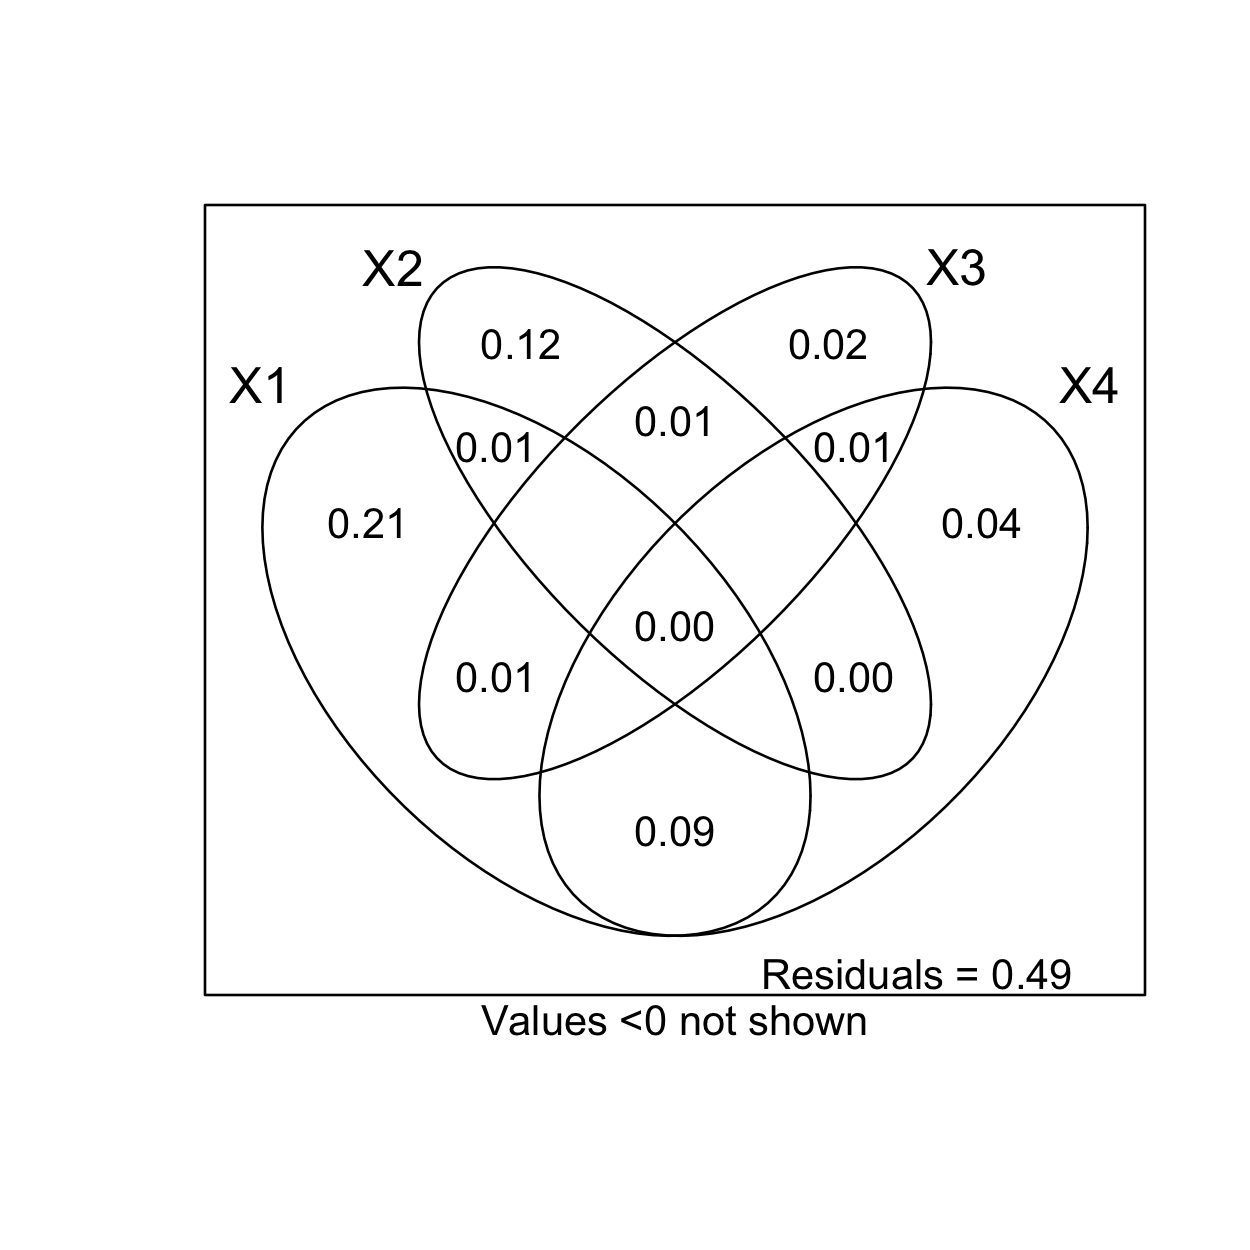

In [11]:
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res = 250)
overview.vp <- varpart(gp.dist, 
                       ~ FallPeak + DayLength,
                       ~ SALINITY,
                       ~ LinearTime,
                       ~ PO4F, data=ENV.mini)

overview.vp
plot(overview.vp)

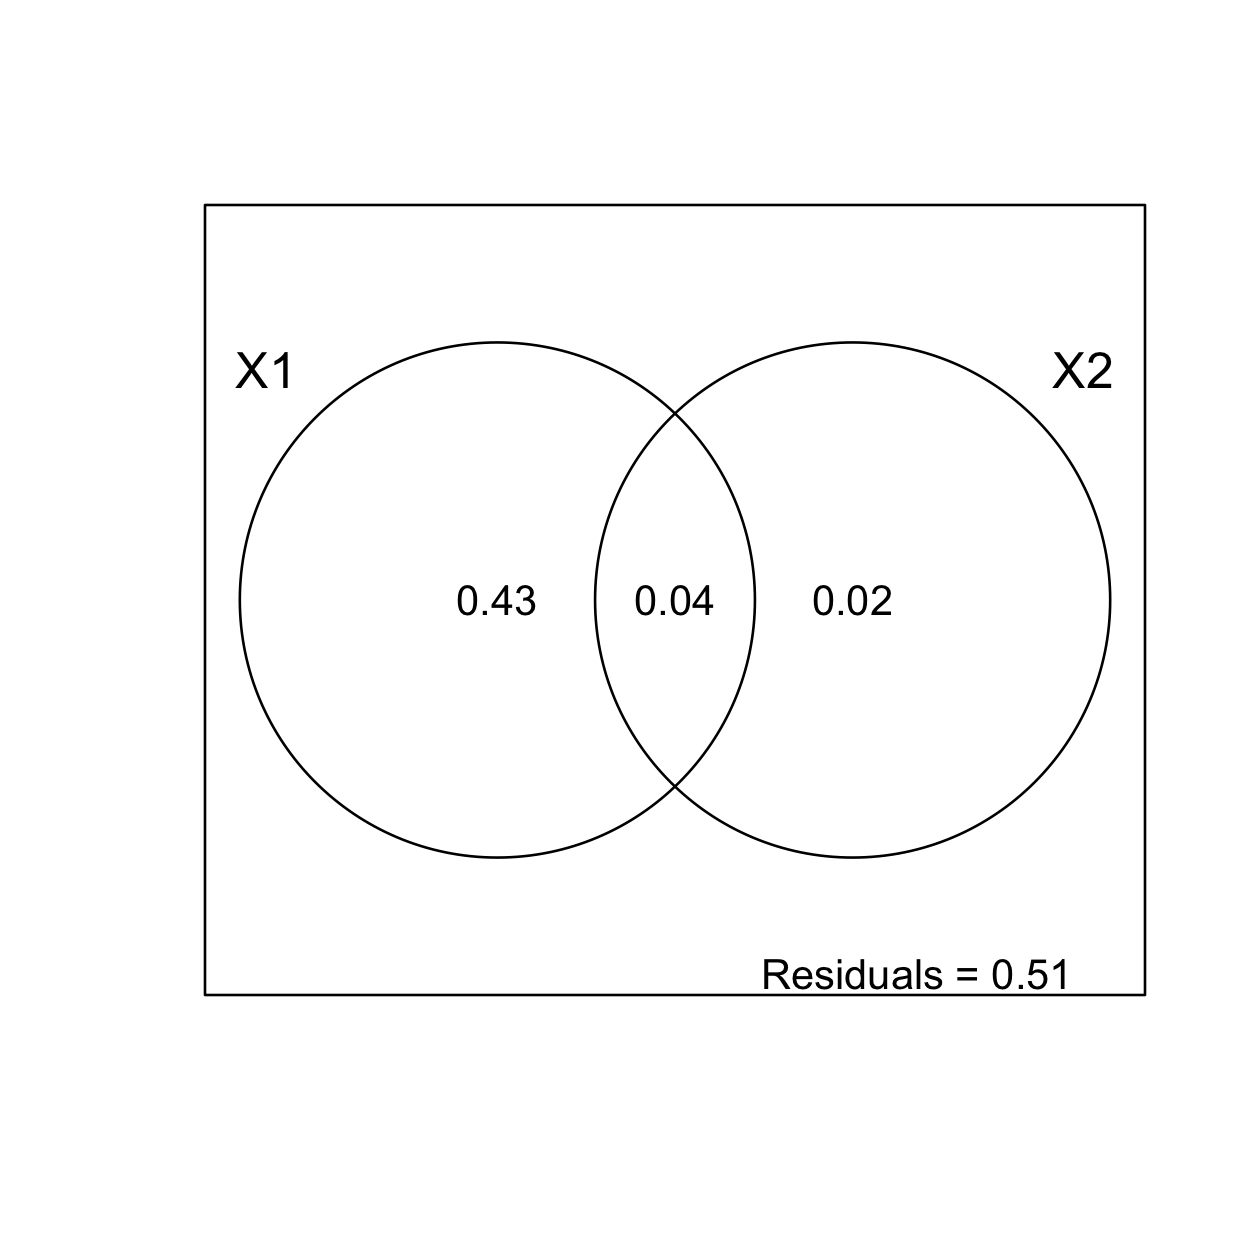

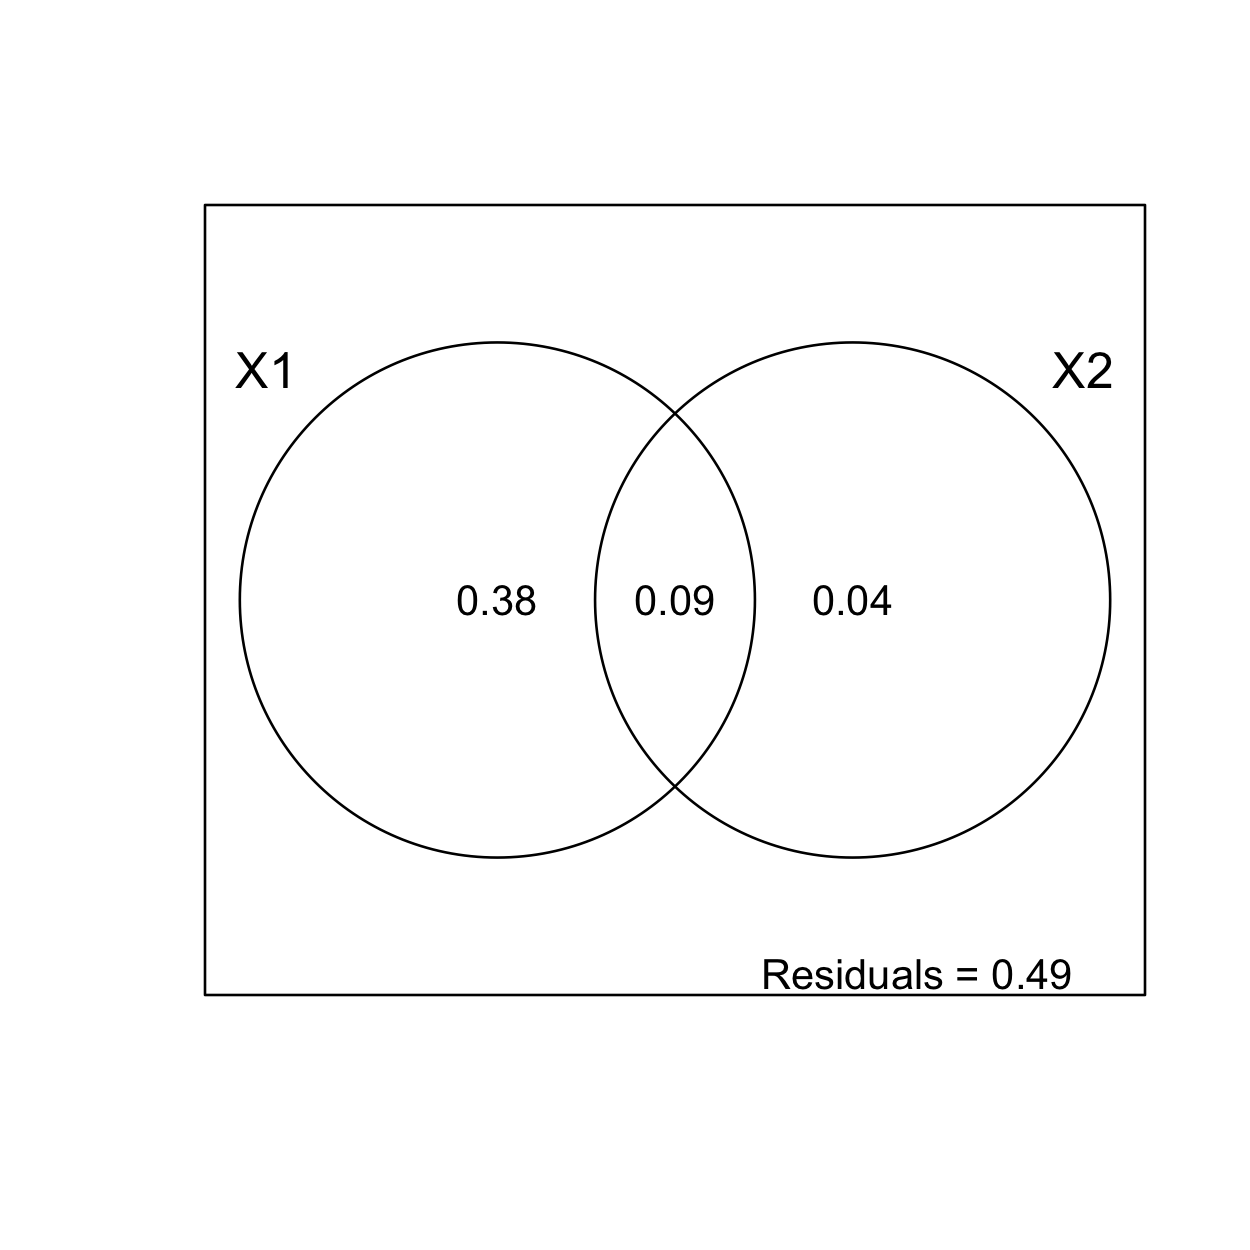

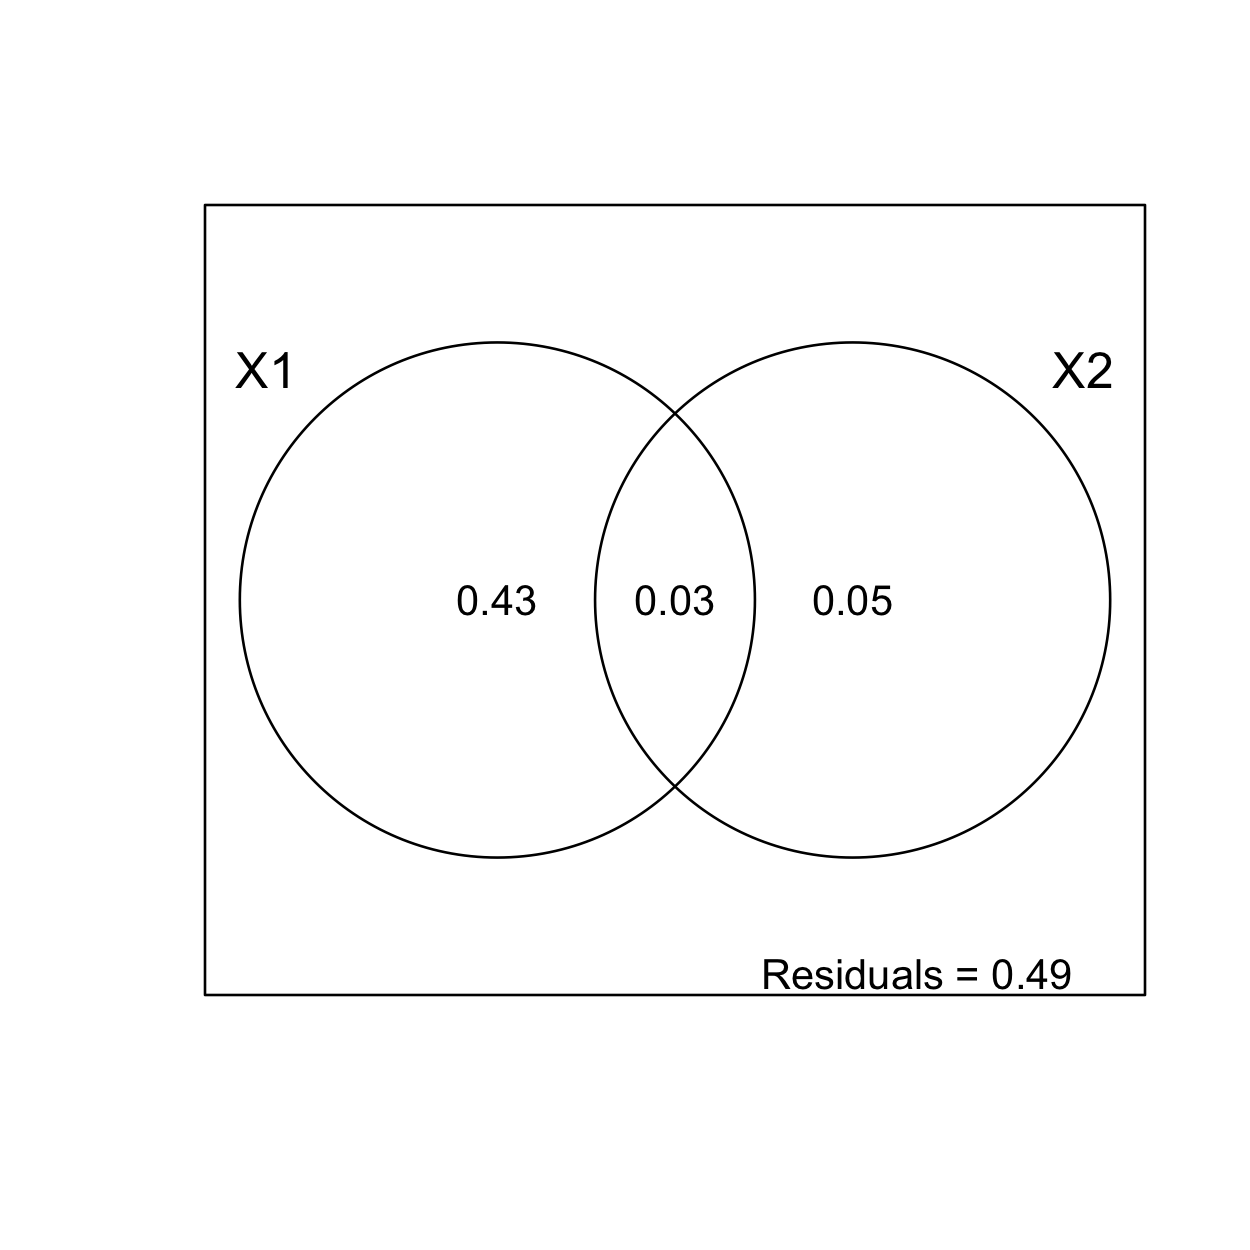

In [12]:
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res = 250)

plot(varpart(gp.dist, ~ FallPeak + SALINITY + LinearTime + DayLength, ~ NO2F,  data=ENV.mini))
plot(varpart(gp.dist, ~ FallPeak + SALINITY + LinearTime + DayLength, ~ PO4F,  data=ENV.mini))
plot(varpart(gp.dist, ~ FallPeak + SALINITY + LinearTime + DayLength, ~ DO,  data=ENV.mini))

flush.console()


In [13]:
ENV.mini.3 = cbind(ENV.mini)
colnames(ENV.mini.3)[colnames(ENV.mini.3) == 'SALINITY'] = 'Salinity'
colnames(ENV.mini.3)[colnames(ENV.mini.3) == 'PO4F'] = 'Phosphate'
colnames(ENV.mini.3)[colnames(ENV.mini.3) == 'FallPeak'] = 'Seasonality'
impo_names = c('Microbial.Clusters', 'DayLength', 'LinearTime', 'Salinity', 'Phosphate', 'Seasonality', 'Habitat', 'WTEMP', 'TN', 'DO')
ENV.mini.3 = ENV.mini.3[,impo_names]
sample_data(physeq_2) <- sample_data(ENV.mini.3)

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘tidytree’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘tidytree’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘tidytree’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘tidytree’



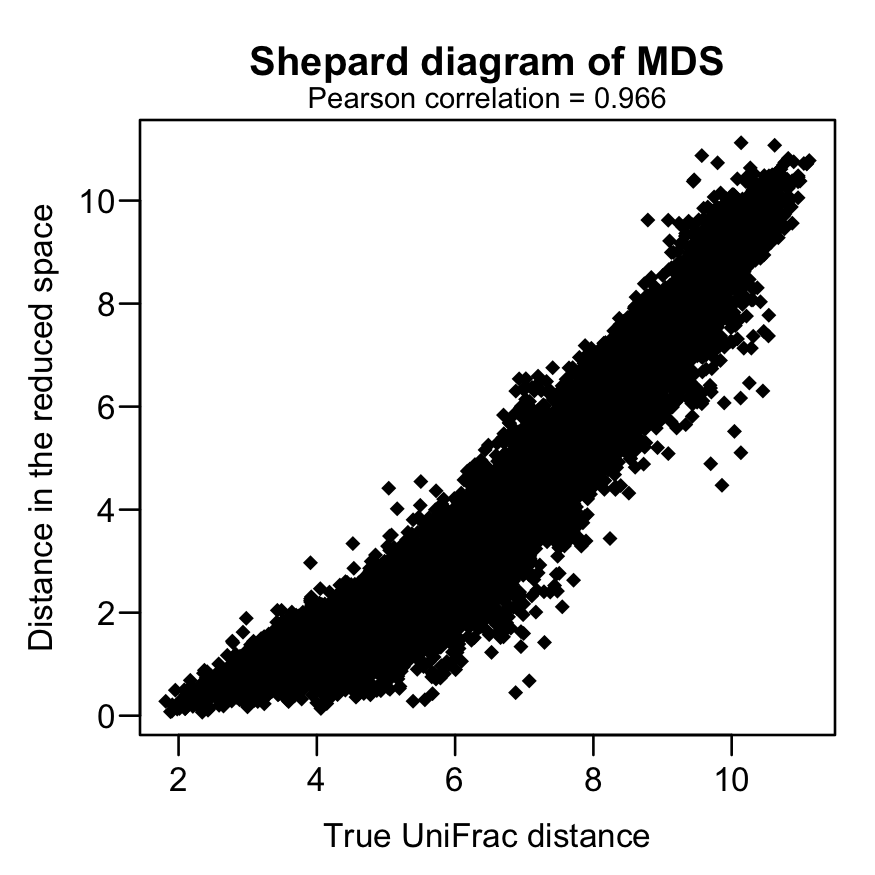

In [14]:
set.seed(100)
wUF.nmds.3D = metaMDS(gp.dist, method="NMDS", k=3, trymax=1000, trace=0)

options(repr.plot.width=3.5, repr.plot.height=3.5)
par(mfrow = c(1,1), mar = c(3.5,3.5,3,1), mgp = c(2, 0.6, 0), cex = 0.8, las = 1)
pears <- round(cor(gp.dist, dist(wUF.nmds.3D$points), method = "pearson"),3)
plot(gp.dist, dist(wUF.nmds.3D$points), main = "Shepard diagram of MDS", 
     xlab = "True UniFrac distance", ylab = "Distance in the reduced space", pch=18)
mtext(line = 0.1, text = paste0("Pearson correlation = ", pears), cex = 0.7)


1-Dim      2-Dim      3-Dim 
0.33838864 0.14857452 0.08744539

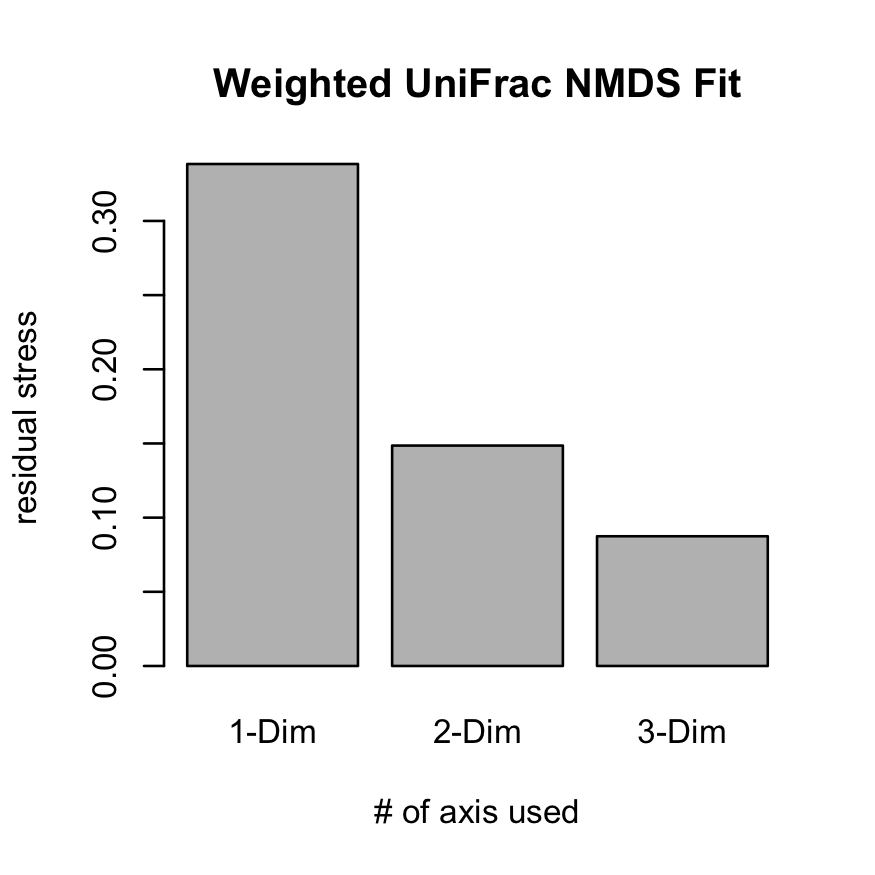

In [15]:
n = 3
stress <- rep(0, n)
for (i in 1:n) {
    stress[i] <- metaMDS(gp.dist, trymax=100, k = i, trace=0)$stress
}
names(stress) <- paste(1:n, "Dim", sep="-")
#stress
par(cex=0.8)
barplot(stress, ylab = "residual stress", xlab='# of axis used')
title('Weighted UniFrac NMDS Fit')
stress

In [15]:
ENV.mini.3$Habitat.Clusters <- factor(paste('H', ENV.mini.3$Habitat, sep="."))

ENV.mini.3$CrossClusters = paste(as.character(ENV.mini.3$Microbial.Clusters), 
                                 as.character(ENV.mini.3$Habitat.Clusters), sep="+")
table(ENV.mini.3$CrossClusters)

cross_ref = table(ENV.mini.3$Microbial.Clusters, ENV.mini.3$Habitat.Clusters)
cross_ref
two_way_corresp = cbind((diag(cross_ref) / colSums(cross_ref)) , 
                        (diag(cross_ref) / rowSums(cross_ref)))
two_way_corresp
per_class_corresp = apply(two_way_corresp, 1, mean)
per_class_corresp
mean(per_class_corresp)
(17*2)/(54 + 61 + 34  + 27 + 26 + 17*2)


M.1+H.1 M.1+H.3 M.2+H.1 M.2+H.2 M.2+H.3 M.3+H.1 M.3+H.2 M.3+H.3 
     54      17      26      61      27      14       3      34 

     
      H.1 H.2 H.3
  M.1  54   0  17
  M.2  26  61  27
  M.3  14   3  34

H.1,0.5744681,0.7605634
H.2,0.9531250,0.5350877
H.3,0.4358974,0.6666667


H.1       H.2       H.3 
0.6675157 0.7441064 0.5512821

[1] 0.6543014

[1] 0.1440678

In [56]:
table(ENV.mini[rownames(ENV.mini.3)[ENV.mini.3$Microbial.Clusters == 'M.1'], 'StatName'])
(22+25+15)/(22+25+15+2+3+4)

table(c(ENV.mini[rownames(ENV.mini.3)[ENV.mini.3$CrossClusters == 'M.2+H.1'], 'StatName'], 
        ENV.mini[rownames(ENV.mini.3)[ENV.mini.3$CrossClusters == 'M.3+H.1'], 'StatName']))

env_data_orig[rownames(ENV.mini.3)[ENV.mini.3$Microbial.Clusters == 'M.3'], 'SampleDate']

length(unique(env_data_orig[rownames(ENV.mini.3)[ENV.mini.3$Microbial.Clusters == 'M.3'], 'Station']))
table(env_data_orig[rownames(ENV.mini.3)[ENV.mini.3$Microbial.Clusters == 'M.3'], 'WaterColumnPosition'])
length(unique(env_data_orig[, 'Station']))
colnames(env_data_orig)


 1  2  3  4  5  6  7 
22 25 15  2  3  4  0 

[1] 0.8732394


 1  2  3  4  5 
 3 11 10  8  8 

[1] "2017-04-11 00:00:00" "2017-04-11 00:00:00" "2017-04-11 00:00:00"
 [4] "2017-04-11 00:00:00" "2017-04-11 00:00:00" "2017-04-10 00:00:00"
 [7] "2017-04-11 00:00:00" "2017-04-10 00:00:00" "2017-04-10 00:00:00"
[10] "2017-04-10 00:00:00" "2017-04-10 00:00:00" "2017-04-10 00:00:00"
[13] "2017-04-13 00:00:00" "2017-04-11 00:00:00" "2017-04-11 00:00:00"
[16] "2017-04-11 00:00:00" "2017-04-11 00:00:00" "2017-04-12 00:00:00"
[19] "2017-04-12 00:00:00" "2017-04-12 00:00:00" "2017-04-12 00:00:00"
[22] "2017-04-13 00:00:00" "2017-04-13 00:00:00" "2017-04-11 00:00:00"
[25] "2017-05-09 00:00:00" "2017-05-08 00:00:00" "2017-05-08 00:00:00"
[28] "2017-05-08 00:00:00" "2017-05-08 00:00:00" "2017-05-08 00:00:00"
[31] "2017-05-08 00:00:00" "2017-05-08 00:00:00" "2017-05-09 00:00:00"
[34] "2017-05-09 00:00:00" "2017-05-09 00:00:00" "2017-05-09 00:00:00"
[37] "2017-05-09 00:00:00" "2017-05-11 00:00:00" "2017-05-11 00:00:00"
[40] "2017-05-11 00:00:00" "2017-05-10 00:00:00" "2017-05-10 00:00:00"
[43] "2017-05-09 00:00:00" "2017-05-10 00:00:00" "2017-05-09 00:00:00"
[46] "2017-05-09 00:00:00" "2017-05-09 00:00:00" "2017-05-10 00:00:00"
[49] "2017-06-06 00:00:00" "2017-06-07 00:00:00" "2017-06-08 00:00:00"

[1] 16


lower upper 
   34    17 

[1] 20

[1] "Station"                        "OLD_DATE_TIME"                 
 [3] "OldDepth"                       "qPCR.ct"                       
 [5] "CollectionAgency"               "sequencing_ID"                 
 [7] "TrimCount"                      "TotalDepth"                    
 [9] "PctTotalDepth"                  "WaterColumnPosition"           
[11] "cruise_id"                      "SampleDate"                    
[13] "Depth"                          "PHEO"                          
[15] "TN"                             "TP"                            
[17] "CHLA"                           "DOP"                           
[19] "DON"                            "NH4F"                          
[21] "NO2F"                           "NO3F"                          
[23] "PC"                             "PO4F"                          
[25] "DO"                             "PH"                            
[27] "SALINITY"                       "WTEMP"                         
[29] "LinearTime"                     "DayLength"                     
[31] "FallPeak"                       "SpringPeak"                    
[33] "Discharge_Rappahannock.instant" "Discharge_Rappahannock.15"     
[35] "Discharge_Rappahannock.30"      "Discharge_Rappahannock.60"     
[37] "Discharge_Potomac.instant"      "Discharge_Potomac.15"          
[39] "Discharge_Potomac.30"           "Discharge_Potomac.60"          
[41] "Discharge_Susquehanna.instant"  "Discharge_Susquehanna.15"      
[43] "Discharge_Susquehanna.30"       "Discharge_Susquehanna.60"      
[45] "interpolated_CHLA.instant"      "interpolated_CHLA.15"          
[47] "interpolated_CHLA.30"           "interpolated_CHLA.60"          
[49] "measurement_PAR.instant"        "measurement_PAR.15"            
[51] "measurement_PAR.30"             "measurement_PAR.60"            
[53] "WIND_RATIO_BWI.instant"         "WIND_RATIO_BWI.15"             
[55] "WIND_RATIO_BWI.30"              "WIND_RATIO_BWI.60"             
[57] "PRECIP24HR_BWI.instant"         "PRECIP24HR_BWI.15"             
[59] "PRECIP24HR_BWI.30"              "PRECIP24HR_BWI.60"             
[61] "Discharge_Sum.instant"          "Discharge_Sum.15"              
[63] "Discharge_Sum.30"               "Discharge_Sum.60"              
[65] "Latitude"                       "Longitude"

In [33]:
disp_vars = c('Salinity', 'DO', 'WTEMP')


fit.swUF = envfit(wUF.nmds.3D, ENV.mini.3[,  disp_vars])
fit.swUF
fit.swUF2 = envfit(wUF.nmds.3D, ENV.mini.3[, disp_vars], choices=c(2,3))
fit.swUF2
fit.swUF3 = envfit(wUF.nmds.3D, ENV.mini.3[, disp_vars], choices=c(1,3))
fit.swUF3


***VECTORS

            NMDS1    NMDS2     r2 Pr(>r)    
Salinity -0.09612  0.99537 0.7879  0.001 ***
DO        0.99422  0.10734 0.2018  0.001 ***
WTEMP    -0.99576 -0.09199 0.7939  0.001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Permutation: free
Number of permutations: 999




***VECTORS

            NMDS2    NMDS3     r2 Pr(>r)    
Salinity  0.96296  0.26963 0.8090  0.001 ***
DO        0.07302 -0.99733 0.1442  0.001 ***
WTEMP    -0.30282 -0.95305 0.0259  0.035 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Permutation: free
Number of permutations: 999




***VECTORS

            NMDS1    NMDS3     r2 Pr(>r)    
Salinity -0.32604  0.94536 0.0452  0.006 ** 
DO        0.56125 -0.82764 0.3432  0.001 ***
WTEMP    -0.96023 -0.27920 0.8117  0.001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Permutation: free
Number of permutations: 999



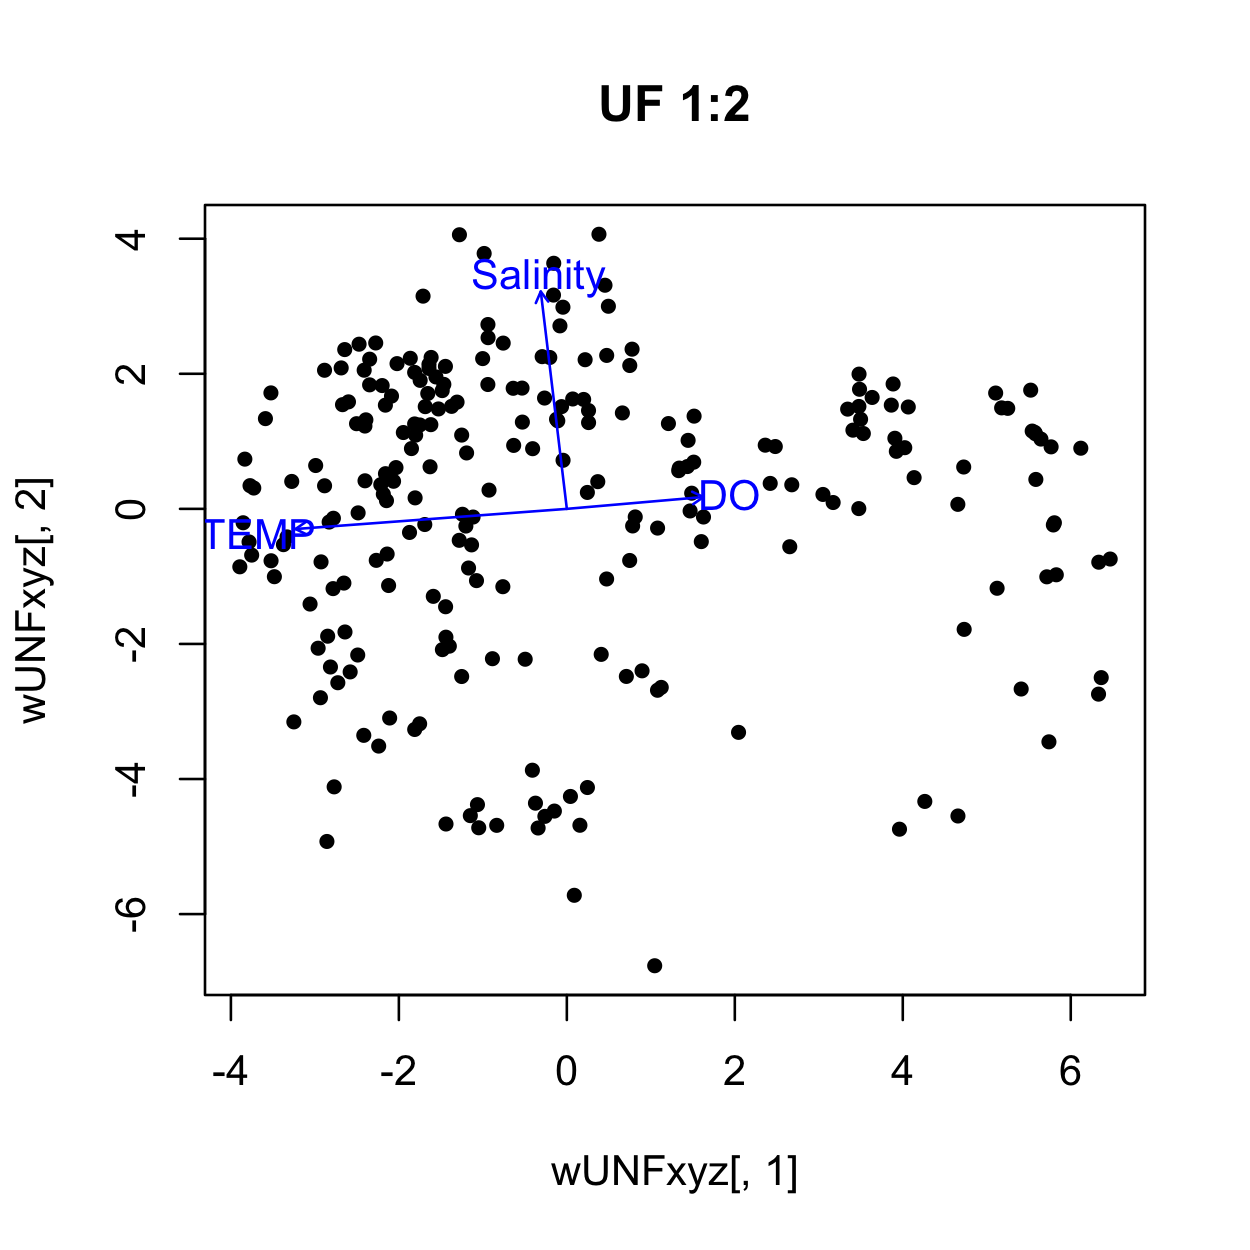

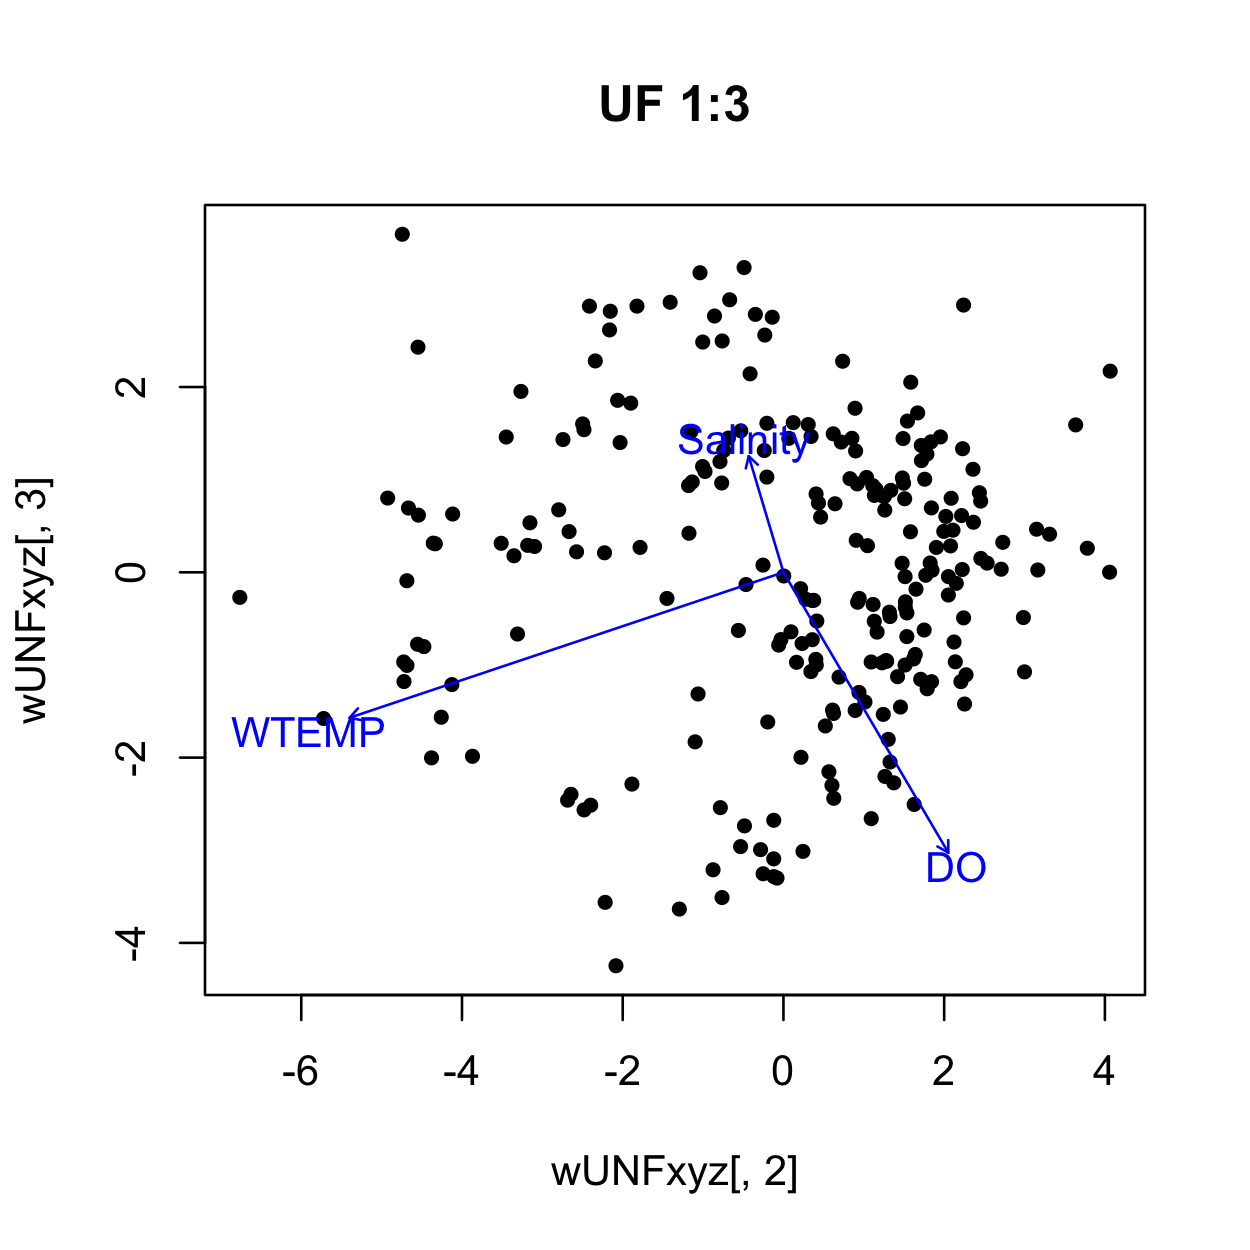

In [34]:
options(repr.plot.width=5, repr.plot.height=5)
wUNFxyz = scores(wUF.nmds.3D, display="sites")

plot(wUNFxyz[,1], wUNFxyz[,2], main="UF 1:2", pch=20)
plot(fit.swUF, add=T)
plot(wUNFxyz[,2], wUNFxyz[,3], main="UF 1:3", pch=20)
plot(fit.swUF3, add=T)

NMDS1              NMDS2              NMDS3 Microbial.Clusters 
         "numeric"          "numeric"          "numeric"           "factor" 
         DayLength         LinearTime           Salinity          Phosphate 
         "numeric"          "numeric"          "numeric"          "numeric" 
       Seasonality            Habitat              WTEMP                 TN 
         "numeric"           "factor"          "numeric"          "numeric" 
                DO   Habitat.Clusters      CrossClusters 
         "numeric"           "factor"        "character"

,NMDS1,NMDS2
Salinity,-0.3668767,3.7992011
DO,1.9205360,0.2073516
WTEMP,-3.8151480,-0.3524689


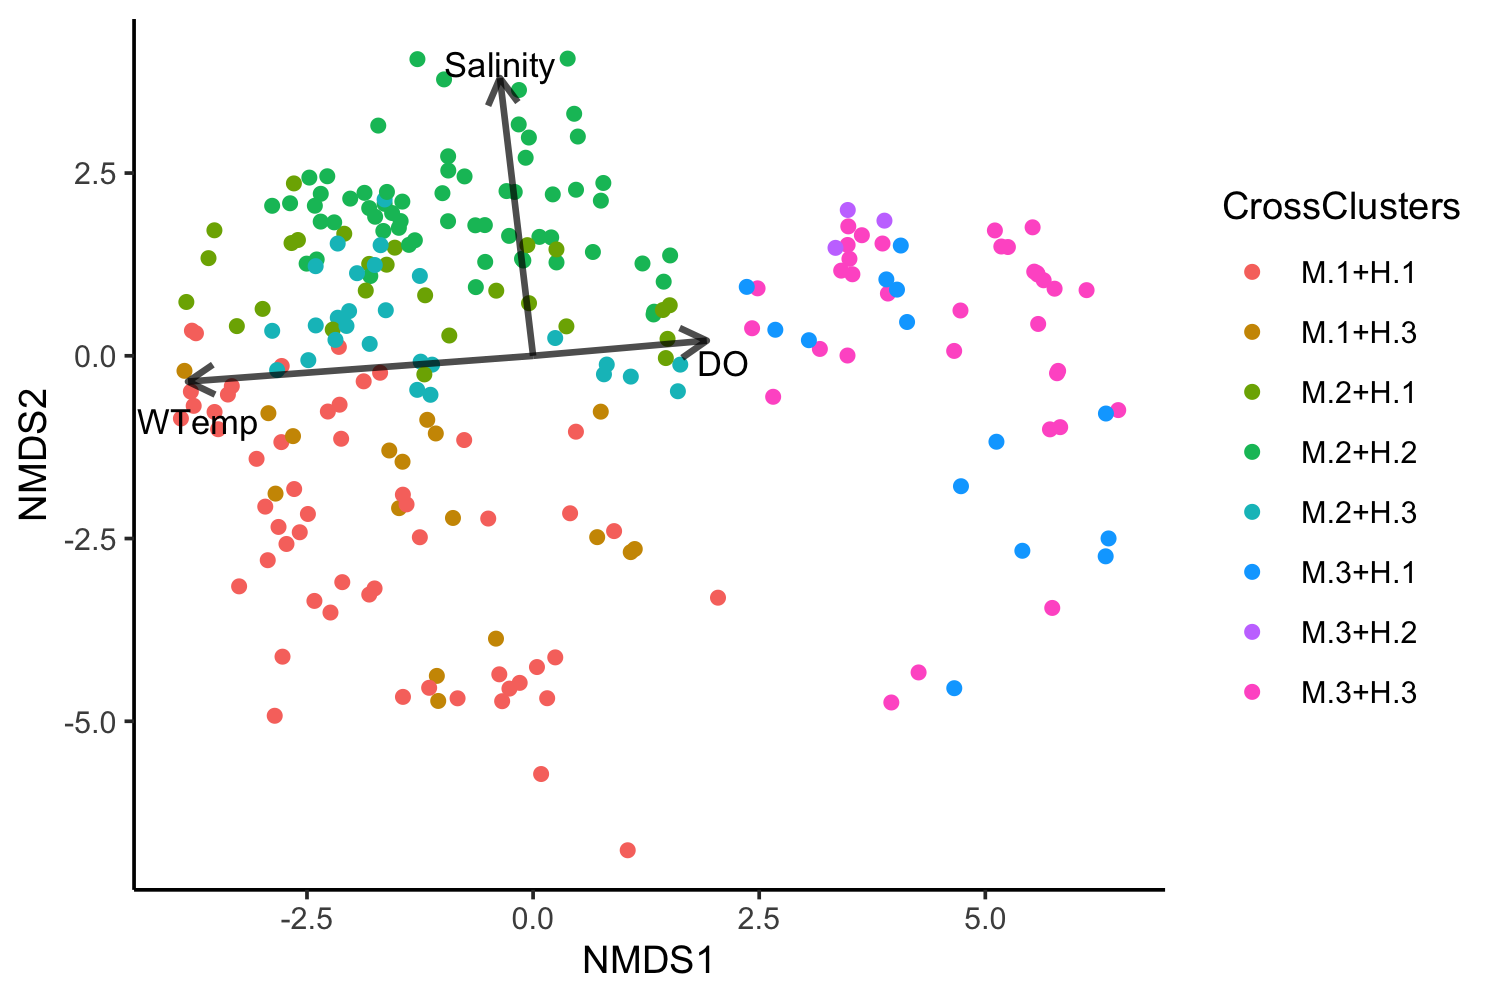

In [35]:
library(ggplot2)

mini.vectors.12 = c('WTEMP', 'Salinity', 'DO')
colnames(wUNFxyz) <- c('NMDS1', 'NMDS2', 'NMDS3')
plot.df.mini = cbind.data.frame(wUNFxyz, ENV.mini.3)
sapply(plot.df.mini, class)

spp.scrs <- as.data.frame(scores(fit.swUF, display = "vectors"))
spp.scrs <- apply(spp.scrs, MARGIN=2, FUN=function(x) {x*4.3})
spp.scrs = spp.scrs[which(rownames(spp.scrs) != 'DayLength'),]
spp.scrs

options(repr.plot.width=6, repr.plot.height=4)
sp2<-ggplot(plot.df.mini, aes(x=NMDS1, y=NMDS2)) + 
              geom_point(aes(color=CrossClusters)) + theme_classic() + 
#              scale_color_manual(values = c("M.1+H.1" = "blue",  'M.1+H.3' =' chartreuse',
#                                            "M.2+H.2" = "red1",  'M.2+H.1' ='orchid3', 'M.2+H.3'='orange1',
#                                            'M.3+H.3' = 'gold2', 'M.3+H.2' = 'darkorange2', 'M.3+H.1'= 'forestgreen')) + 
              annotate("segment", x = 0, xend = spp.scrs[,'NMDS1'],y = 0, yend = spp.scrs[,'NMDS2'], alpha=0.7,
                       colour = "black", size=0.9, arrow=arrow(length = unit(0.12, "inches"))) + 
              annotate('text', 
                        x= c(-0.36, 2.1, -3.7), 
                        y= c(3.99, -0.1, -.90), 
                        label=c('Salinity', 'DO', 'WTemp'),
                        color='black', alpha=1.0, size=3.5)
sp2



In [36]:
mean(env_data_orig[rownames(ENV.mini.3)[ENV.mini.3$CrossClusters == 'M.1+H.3'], 'DO'])
sd(env_data_orig[rownames(ENV.mini.3)[ENV.mini.3$CrossClusters == 'M.1+H.3'], 'DO'])

[1] 8.491961

[1] 1.329591

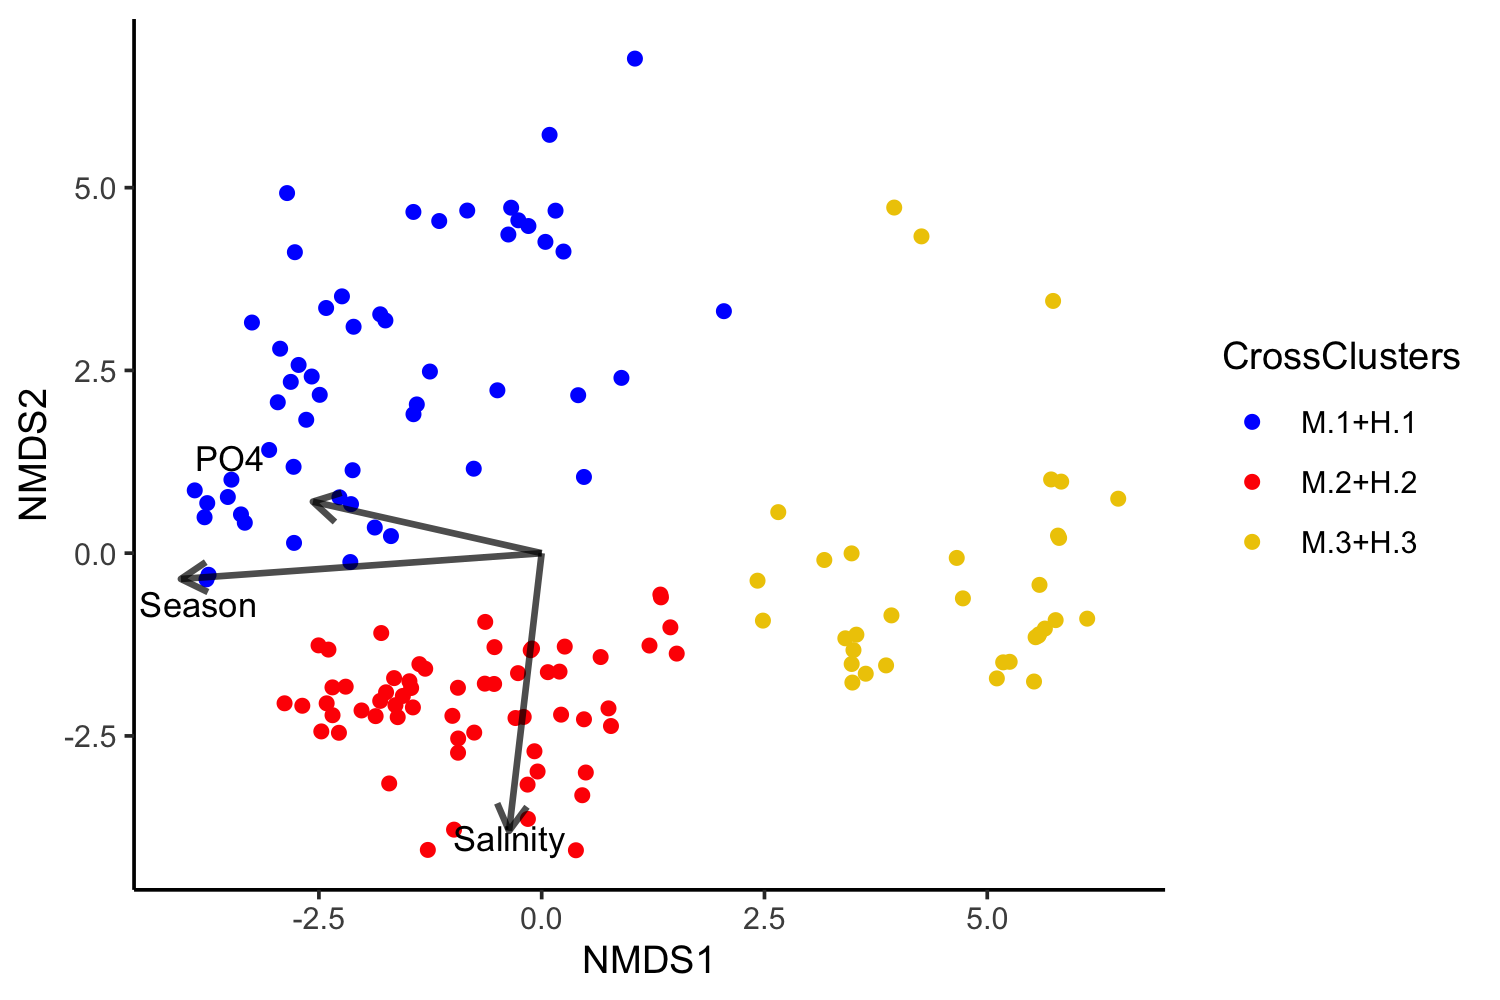

In [36]:
options(repr.plot.width=6, repr.plot.height=4)
alldropped = c('M.1+H.3' ,'M.2+H.1' , 'M.3+H.2', 'M.2+H.3', 'M.3+H.1')
all_in = c("M.1+H.1", "M.2+H.2", 'M.3+H.3')
plot.df.mini.drop.all = plot.df.mini[which(plot.df.mini$CrossClusters %in% all_in), ]


sp2<-ggplot(plot.df.mini.drop.all, aes(x=NMDS1, y=NMDS2)) + 
              geom_point(aes(color=CrossClusters)) + theme_classic() + 
              scale_color_manual(values = c("M.1+H.1" = "blue",  'M.1+H.3' =' chartreuse',
                                            "M.2+H.2" = "red1",  'M.2+H.1' ='orchid3', 'M.2+H.3'='orange1',
                                            'M.3+H.3' = 'gold2', 'M.3+H.2' = 'darkorange2', 'M.3+H.1'= 'forestgreen')) + 
              annotate("segment", x = 0, xend = spp.scrs[,'NMDS1'],y = 0, yend = spp.scrs[,'NMDS2'], alpha=0.7,
                       colour = "black", size=0.9, arrow=arrow(length = unit(0.12, "inches")))  + 
              annotate('text', 
                        x= c(-0.36, -3.5, -3.85), 
                        y= c(-3.9, 1.3, -.70), 
                        label=c('Salinity', 'PO4', 'Season'),
                        color='black', alpha=1.0, size=3.5)
sp2



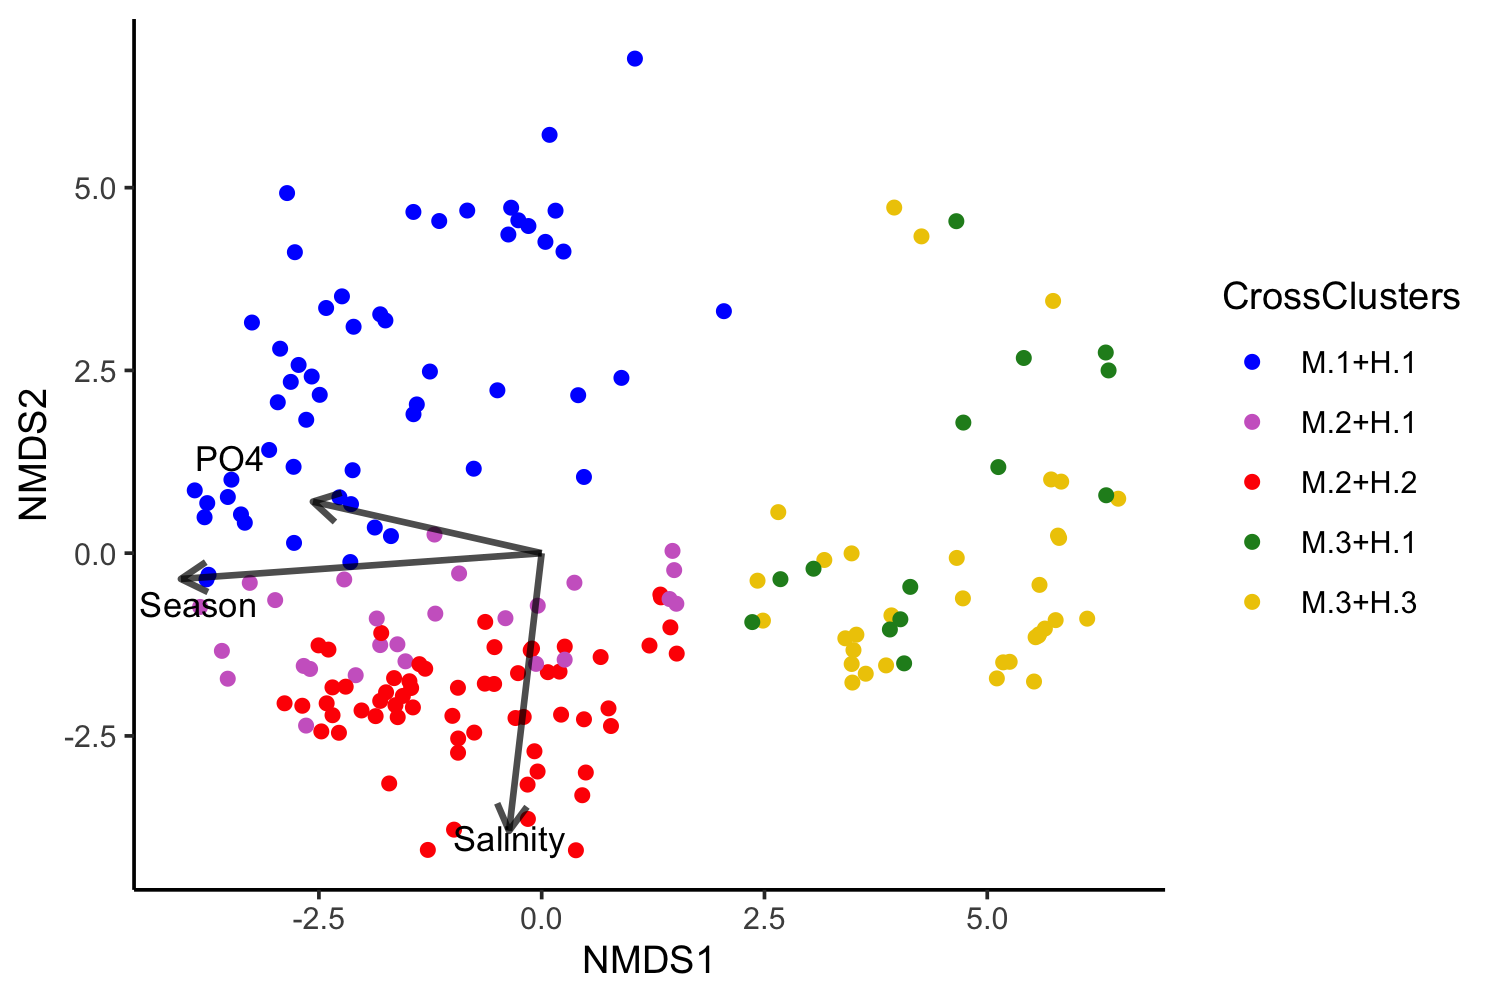

In [37]:
alldropped = c('M.1+H.3', 'M.3+H.2', 'M.2+H.3')
all_in2 = c("M.1+H.1", "M.2+H.2", 'M.3+H.3', 'M.2+H.1', 'M.3+H.1')
plot.df.mini.drop.some = plot.df.mini[which(plot.df.mini$CrossClusters %in% all_in2), ]


sp2<-ggplot(plot.df.mini.drop.some, aes(x=NMDS1, y=NMDS2)) + 
              geom_point(aes(color=CrossClusters)) + theme_classic() + 
              scale_color_manual(values = c("M.1+H.1" = "blue",  'M.1+H.3' =' chartreuse',
                                            "M.2+H.2" = "red1",  'M.2+H.1' ='orchid3', 'M.2+H.3'='orange1',
                                            'M.3+H.3' = 'gold2', 'M.3+H.2' = 'darkorange2', 'M.3+H.1'= 'forestgreen')) + 
              annotate("segment", x = 0, xend = spp.scrs[,'NMDS1'],y = 0, yend = spp.scrs[,'NMDS2'], alpha=0.7,
                       colour = "black", size=0.9, arrow=arrow(length = unit(0.12, "inches")))  + 
              annotate('text', 
                        x= c(-0.36, -3.5, -3.85), 
                        y= c(-3.9, 1.3, -.70), 
                        label=c('Salinity', 'PO4', 'Season'),
                        color='black', alpha=1.0, size=3.5)

sp2


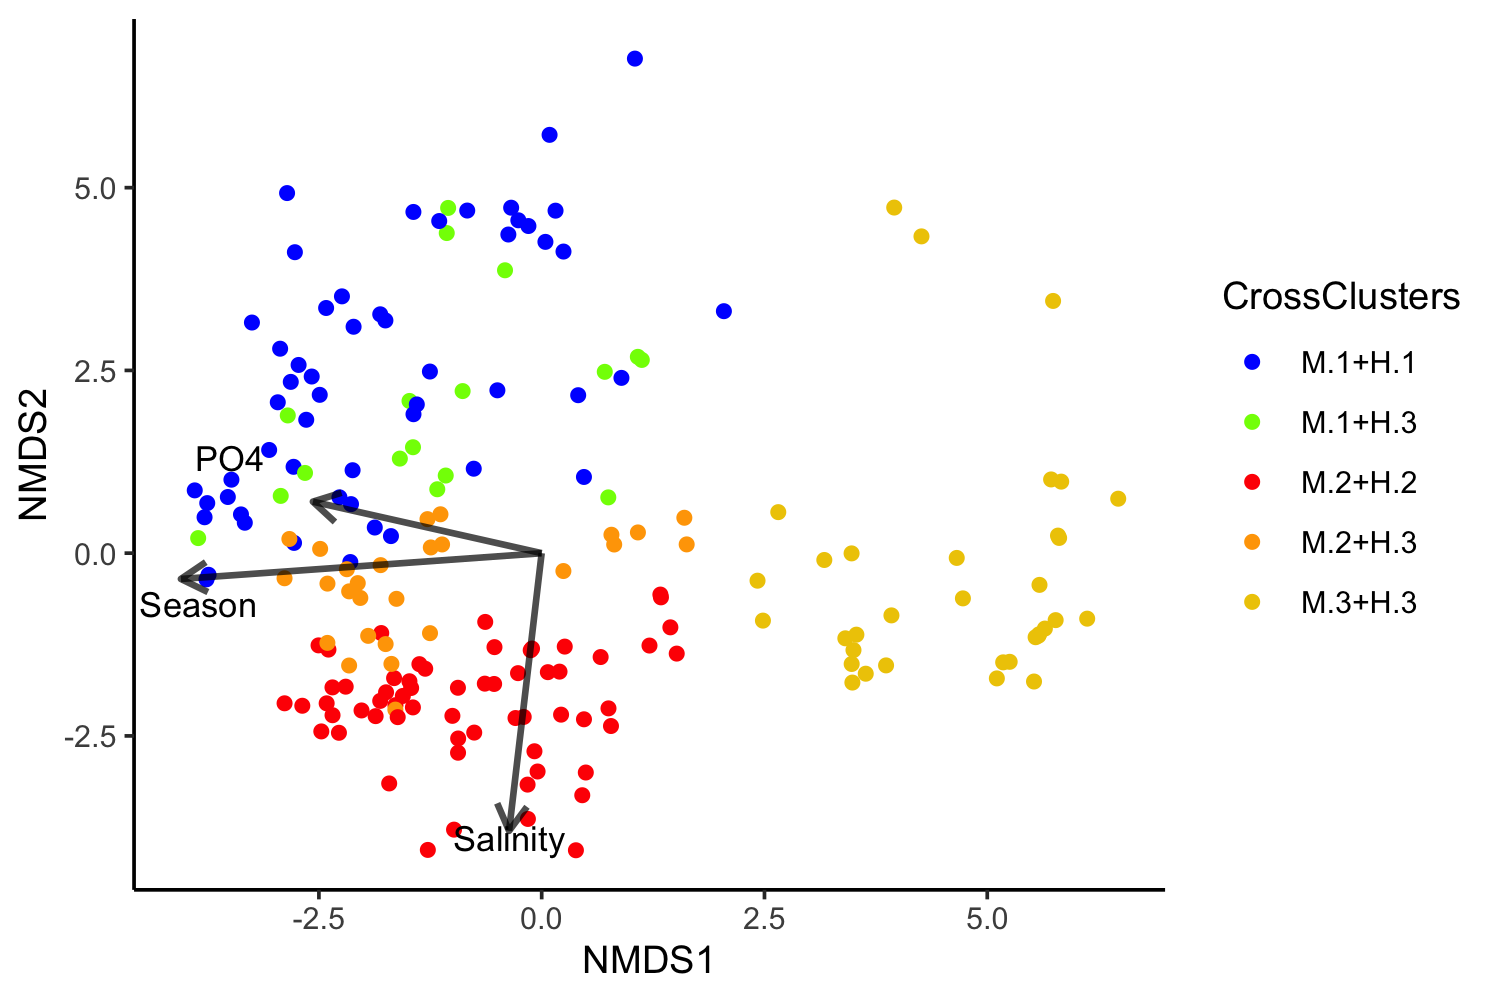

In [40]:
alldropped = c('M.1+H.3', 'M.3+H.2', 'M.2+H.3')
all_in2 = c("M.1+H.1", "M.2+H.2", 'M.3+H.3', 'M.1+H.3', 'M.2+H.3')
plot.df.mini.drop.some = plot.df.mini[which(plot.df.mini$CrossClusters %in% all_in2), ]


sp2<-ggplot(plot.df.mini.drop.some, aes(x=NMDS1, y=NMDS2)) + 
              geom_point(aes(color=CrossClusters)) + theme_classic() + 
              scale_color_manual(values = c("M.1+H.1" = "blue",  'M.1+H.3' =' chartreuse',
                                            "M.2+H.2" = "red1",  'M.2+H.3'='orange1',
                                            'M.3+H.3' = 'gold2')) + 
              annotate("segment", x = 0, xend = spp.scrs[,'NMDS1'],y = 0, yend = spp.scrs[,'NMDS2'], alpha=0.7,
                       colour = "black", size=0.9, arrow=arrow(length = unit(0.12, "inches")))  + 
              annotate('text', 
                        x= c(-0.36, -3.5, -3.85), 
                        y= c(-3.9, 1.3, -.70), 
                        label=c('Salinity', 'PO4', 'Season'),
                        color='black', alpha=1.0, size=3.5)

sp2


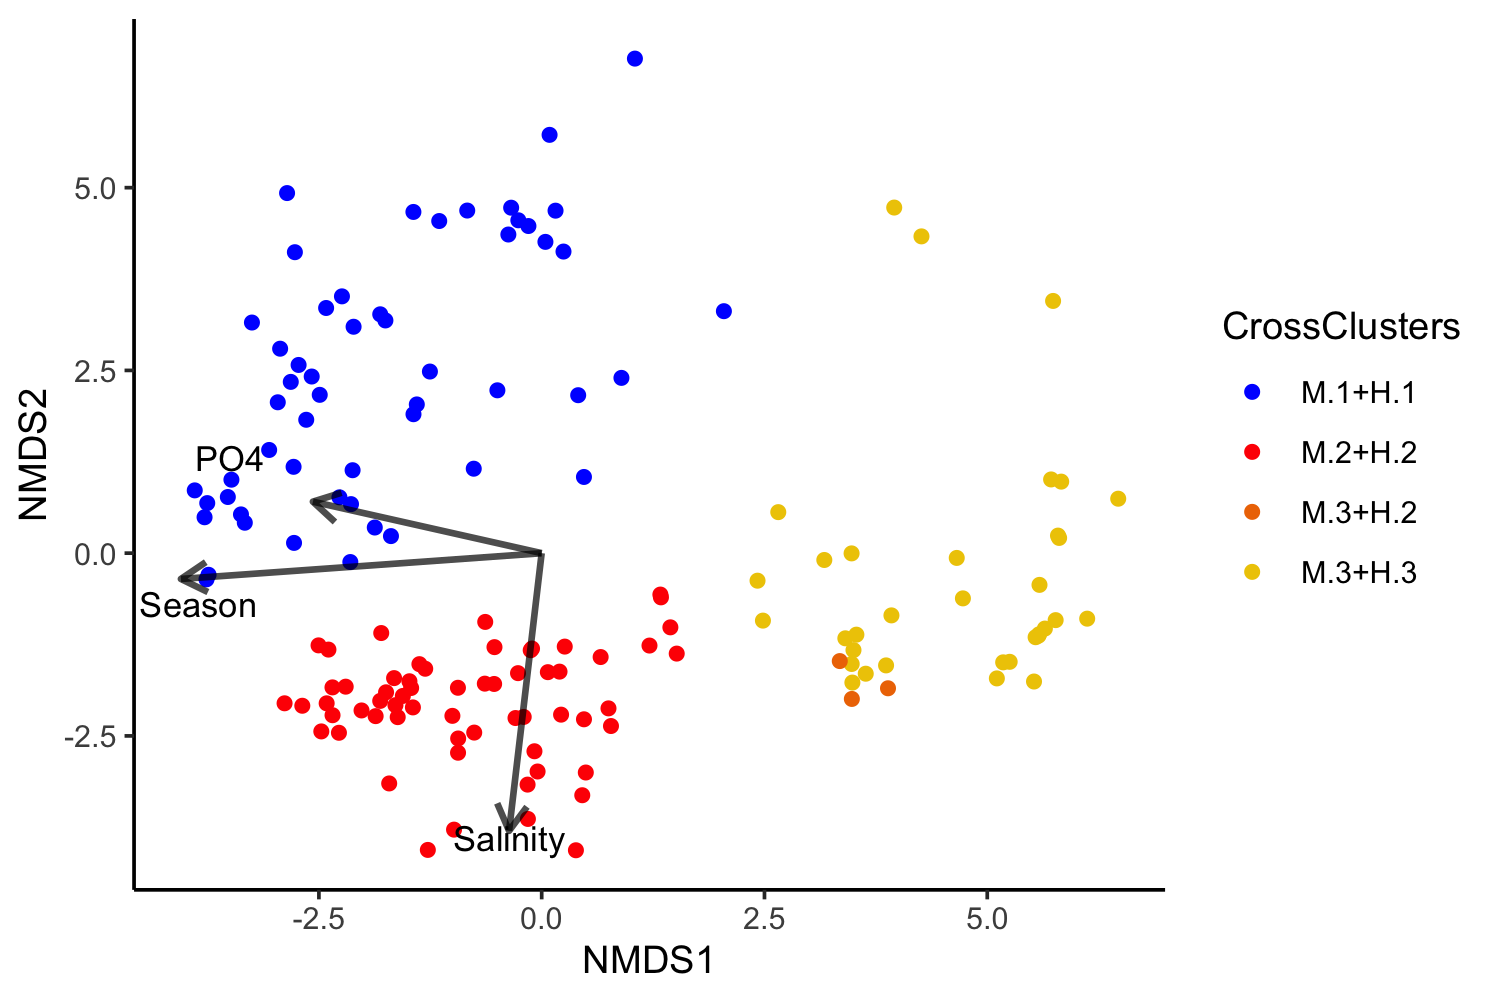

In [42]:
alldropped = c('M.1+H.3', 'M.3+H.2', 'M.2+H.3')
all_in2 = c("M.1+H.1", "M.2+H.2", 'M.3+H.3', 'M.3+H.2')
plot.df.mini.drop.some = plot.df.mini[which(plot.df.mini$CrossClusters %in% all_in2), ]


sp2<-ggplot(plot.df.mini.drop.some, aes(x=NMDS1, y=NMDS2)) + 
              geom_point(aes(color=CrossClusters)) + theme_classic() + 
              scale_color_manual(values = c("M.1+H.1" = "blue",  
                                            "M.2+H.2" = "red1",  'M.3+H.2' = 'darkorange2',
                                            'M.3+H.3' = 'gold2')) + 
              annotate("segment", x = 0, xend = spp.scrs[,'NMDS1'],y = 0, yend = spp.scrs[,'NMDS2'], alpha=0.7,
                       colour = "black", size=0.9, arrow=arrow(length = unit(0.12, "inches")))  + 
              annotate('text', 
                        x= c(-0.36, -3.5, -3.85), 
                        y= c(-3.9, 1.3, -.70), 
                        label=c('Salinity', 'PO4', 'Season'),
                        color='black', alpha=1.0, size=3.5)

sp2


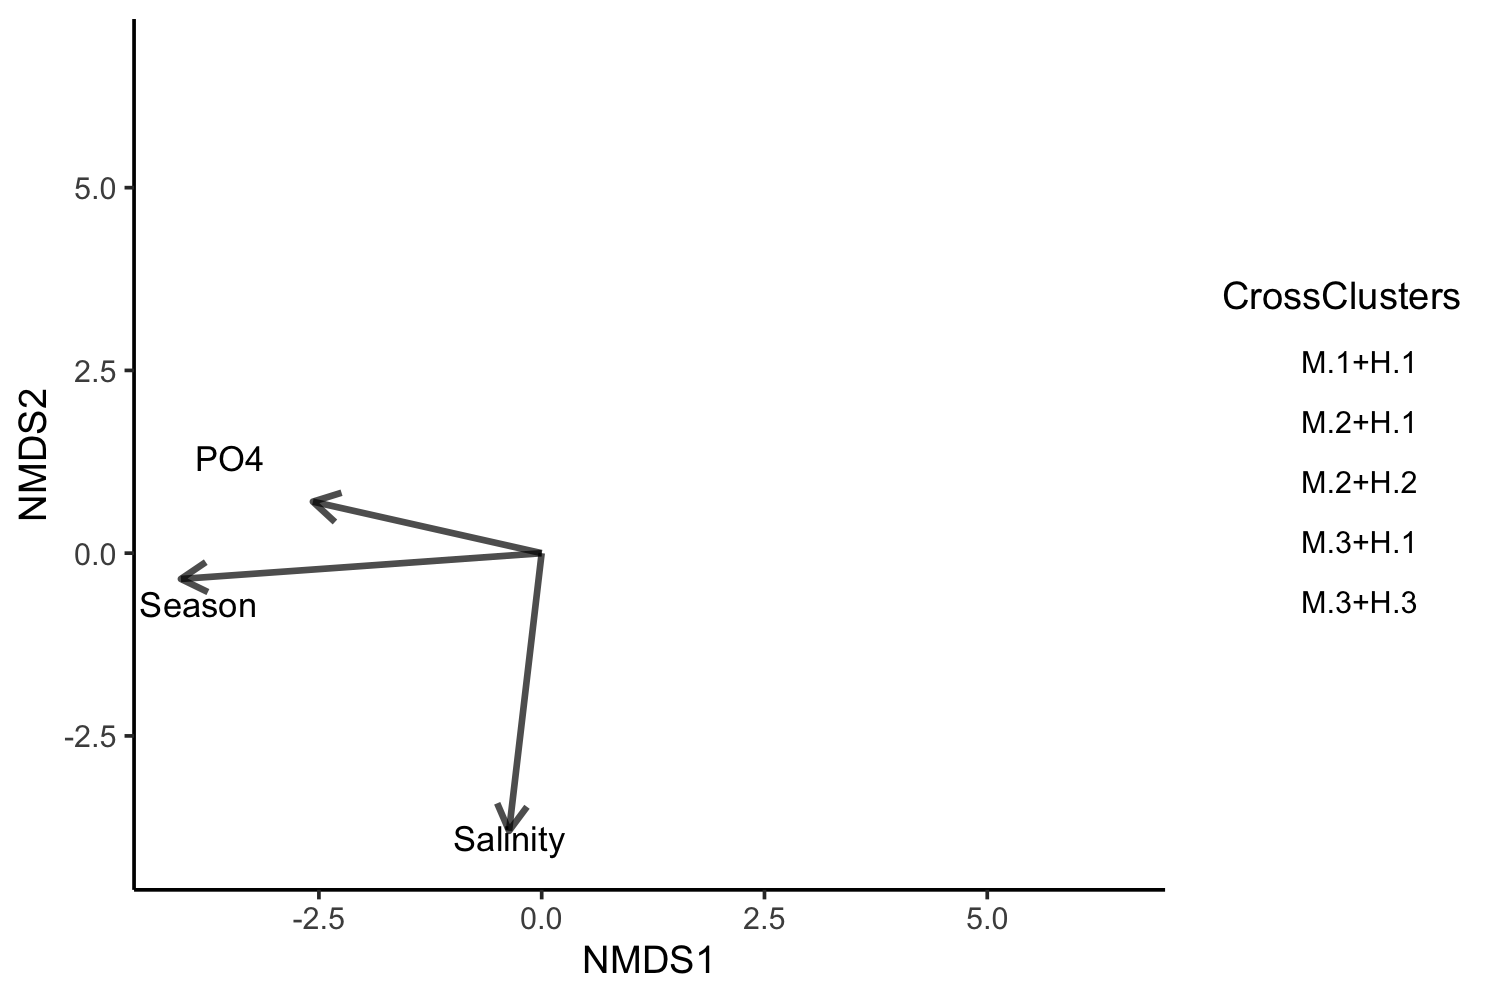

In [52]:
alldropped = c('M.1+H.3', 'M.3+H.2', 'M.2+H.3')
all_in2 = c("M.1+H.1", "M.2+H.2", 'M.3+H.3', 'M.2+H.1', 'M.3+H.1')
plot.df.mini.drop.some = plot.df.mini[which(plot.df.mini$CrossClusters %in% all_in2), ]


sp2<-ggplot(plot.df.mini.drop.some, aes(x=NMDS1, y=NMDS2)) + 
              geom_point(aes(color=CrossClusters)) + theme_classic() + 
              scale_color_manual(values = c("M.1+H.1" = "white",  'M.1+H.3' =' white',
                                            "M.2+H.2" = "white",  'M.2+H.1' ='white', 'M.2+H.3'='white',
                                            'M.3+H.3' = 'white', 'M.3+H.2' = 'white', 'M.3+H.1'= 'white')) + 
              annotate("segment", x = 0, xend = spp.scrs[,'NMDS1'],y = 0, yend = spp.scrs[,'NMDS2'], alpha=0.7,
                       colour = "black", size=0.9, arrow=arrow(length = unit(0.12, "inches")))  + 
              annotate('text', 
                        x= c(-0.36, -3.5, -3.85), 
                        y= c(-3.9, 1.3, -.70), 
                        label=c('Salinity', 'PO4', 'Season'),
                        color='black', alpha=1.0, size=3.5)

sp2


,NMDS1,NMDS3
Salinity,-0.2766731,-0.8037418
Phosphate,-1.7708062,-2.6585149
Seasonality,-3.7525374,-0.4631911
DayLength,0.4128861,1.7195755


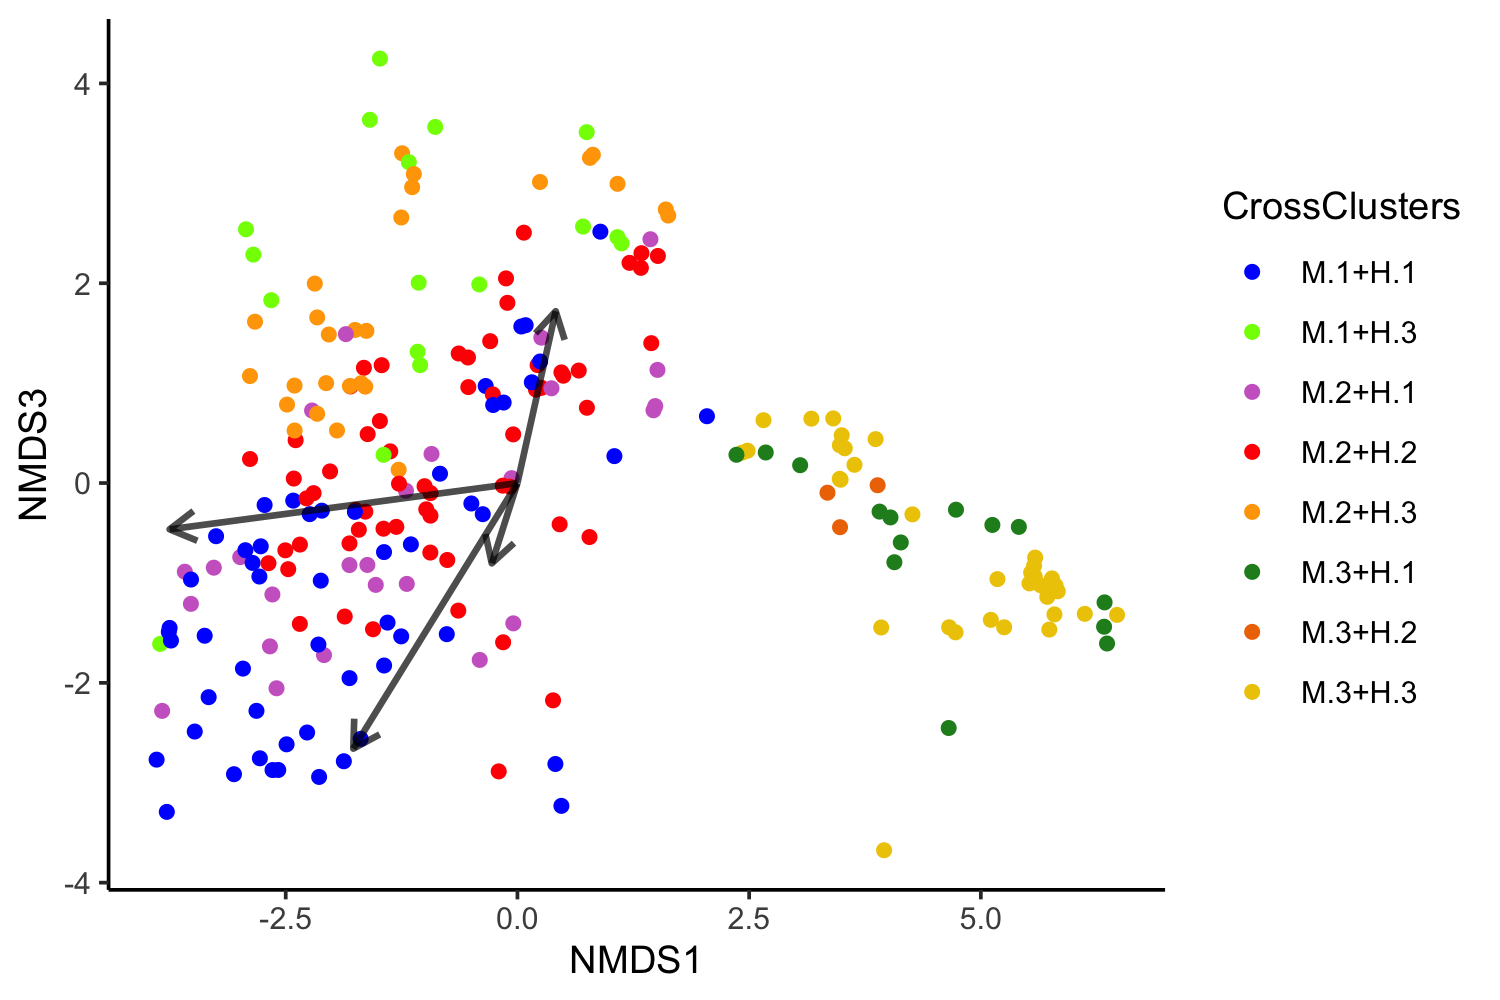

In [53]:
spp.scrs <- as.data.frame(scores(fit.swUF3, display = "vectors"))
spp.scrs <- apply(spp.scrs, MARGIN=2, FUN=function(x) {x*4})
spp.scrs
    
sp3 <- ggplot(plot.df.mini, aes(x=NMDS1, y=NMDS3)) + 
             geom_point(aes(color=CrossClusters)) + theme_classic() + 
              scale_color_manual(values = c("M.1+H.1" = "blue",  'M.1+H.3' =' chartreuse',
                                            "M.2+H.2" = "red1",  'M.2+H.1' ='orchid3', 'M.2+H.3'='orange1',
                                            'M.3+H.3' = 'gold2', 'M.3+H.2' = 'darkorange2', 'M.3+H.1'= 'forestgreen')) + 
              annotate("segment", x = 0, xend = spp.scrs[,'NMDS1'],y = 0, yend = spp.scrs[,'NMDS3'], 
                      alpha=0.7, colour = "black", size=0.9, arrow=arrow(length = unit(0.12, "inches"))) 
#              annotate('text', x= c(-0.264, 0.011, -0.25, 0.23, 0.219), 
#                        y= c(-0.142, -0.35, 0.02, 0.08, -0.117), 
#                        label=c('WTEMP', 'SALINITY', 'PO4F', 'DO', 'NO2F'),
#                        color='black', alpha=1.0, size=4)
sp3




In [54]:
round(cor(sapply(plot.df.mini[,c('NMDS1', 'NMDS2', 'NMDS3', 'Habitat', 'Salinity', 'Seasonality')], as.numeric)), 3)


#head(plot.df.mini)

,NMDS1,NMDS2,NMDS3,Habitat,Salinity,Seasonality
NMDS1,1.000,0.000,0.000,0.310,-0.109,-0.943
NMDS2,0.000,1.000,0.000,-0.241,-0.881,-0.064
NMDS3,0.000,0.000,1.000,0.444,-0.182,-0.067
Habitat,0.310,-0.241,0.444,1.000,0.065,-0.309
Salinity,-0.109,-0.881,-0.182,0.065,1.000,0.160
Seasonality,-0.943,-0.064,-0.067,-0.309,0.160,1.000


In [56]:
write.table(plot.df.mini, file='../data/otu_tables/microbial_community_clusters.txt', sep="\t")

In [40]:
library(readr)
library(tidyverse)
# set up abundace tables
source("../bin/ANCOM/scripts/ancom_v2.1.R")
taxa_abund = round(t(read.delim("../data/otu_tables/taxa_family_abundances.txt", sep="\t", row.names=1)))
fxn_abund = round(t(read.delim("../data/faprotax_data/function_abundances.txt", sep="\t", row.names=1)))
taxa_abund2 = round(t(read.delim("../data/otu_tables/taxa_order_abundances.txt", sep="\t", row.names=1)))
# set up metadata
ENV.mini.ancom = ENV.mini.3[,c('Microbial.Clusters', 'Habitat.Clusters')]
ENV.mini.ancom[,'Sample.ID'] <- rownames(ENV.mini.2)
dim(taxa_abund)
dim(taxa_abund2)
aggr_abunds = rbind.data.frame(taxa_abund, taxa_abund2)
dim(aggr_abunds)
dim(fxn_abund)


Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following object is masked from ‘package:caret’:

    R2


The following object is masked from ‘package:NADA’:

    cor


The following object is masked from ‘package:ape’:

    balance


The following objects are masked from ‘package:stats’:

    cor, cov, dist, var


The following objects are masked from ‘package:base’:

    %*%, norm, scale, scale.default




[1] 477 236

[1] 353 236

[1] 830 236

[1]  91 236

In [58]:
sample_var = "Sample.ID"; group_var = NULL; out_cut = 0.05; zero_cut = 0.90; lib_cut = 0; neg_lb = FALSE

paste('fxn table before:', nrow(fxn_abund), sep=" ")

prepro.f = feature_table_pre_process(fxn_abund, ENV.mini.ancom, sample_var, group_var, 
                                      out_cut, zero_cut, lib_cut, neg_lb)

paste('fxn table after:', nrow(prepro.f$feature_table), sep=" ")

[1] "fxn table before: 91"

[1] "fxn table before: 58"

In [59]:
sample_var = "Sample.ID"; group_var = NULL; out_cut = 0.05; zero_cut = 0.90; lib_cut = 0; neg_lb = FALSE

paste('tax table before:', nrow(aggr_abunds), sep=" ")

prepro.t = feature_table_pre_process(aggr_abunds, ENV.mini.ancom, sample_var, group_var, 
                                      out_cut, zero_cut, lib_cut, neg_lb)

paste('tax table after:', nrow(prepro.t$feature_table), sep=" ")

[1] "tax table before: 830"

[1] "tax table before: 468"

In [60]:
# switch to make everything relative to the largest cluster
prepro.f$meta_data$Microbial.Clusters2 = relevel(prepro.f$meta_data$Microbial.Clusters, ref='M.2')
# run ancom
main_var = "Microbial.Clusters2"; p_adj_method = "BH"; alpha = 0.001; rand_formula = NULL; adj_formula = NULL
t_start = Sys.time()
res.f = ANCOM(prepro.f$feature_table, prepro.f$meta_data, prepro.f$structure_zeros, 
              main_var, p_adj_method, alpha, adj_formula, rand_formula)
t_end = Sys.time()
t_end - t_start 

Time difference of 9.359053 secs

In [61]:
# switch to make everything relative to the largest cluster
prepro.t$meta_data$Microbial.Clusters2 = relevel(prepro.t$meta_data$Microbial.Clusters, ref='M.2')
# run ancom
main_var = "Microbial.Clusters2"; p_adj_method = "BH"; alpha = 0.001; rand_formula = NULL
adj_formula = NULL
t_start = Sys.time()
res.t = ANCOM(prepro.t$feature_table, prepro.t$meta_data, prepro.t$structure_zeros, 
            main_var, p_adj_method, alpha, adj_formula, rand_formula)
t_end = Sys.time()
t_end - t_start 

Time difference of 10.1498 mins

,taxa_id,y,zero_ind,group,x,data.type
,<chr>,<dbl>,<fct>,<chr>,<dbl>,<fct>
17,methanotrophy,0.9655172,No,M.1 relative to M.2,0.52474514,Function (FAPROTAX)
213,acetoclastic_methanogenesis,0.6551724,No,M.1 relative to M.2,-0.17086679,Function (FAPROTAX)
331,methanogenesis_by_CO2_reduction_with_H2,0.7068966,No,M.1 relative to M.2,-0.62025184,Function (FAPROTAX)
411,hydrogenotrophic_methanogenesis,0.7068966,No,M.1 relative to M.2,-0.76016160,Function (FAPROTAX)
513,methanogenesis,0.7068966,No,M.1 relative to M.2,-0.86449088,Function (FAPROTAX)
617,methanol_oxidation,0.6379310,No,M.1 relative to M.2,0.51129854,Function (FAPROTAX)
710,methylotrophy,0.6551724,No,M.1 relative to M.2,0.70792331,Function (FAPROTAX)
813,aerobic_ammonia_oxidation,0.7758621,No,M.1 relative to M.2,0.76183603,Function (FAPROTAX)
914,aerobic_nitrite_oxidation,0.9310345,No,M.1 relative to M.2,-0.98837419,Function (FAPROTAX)


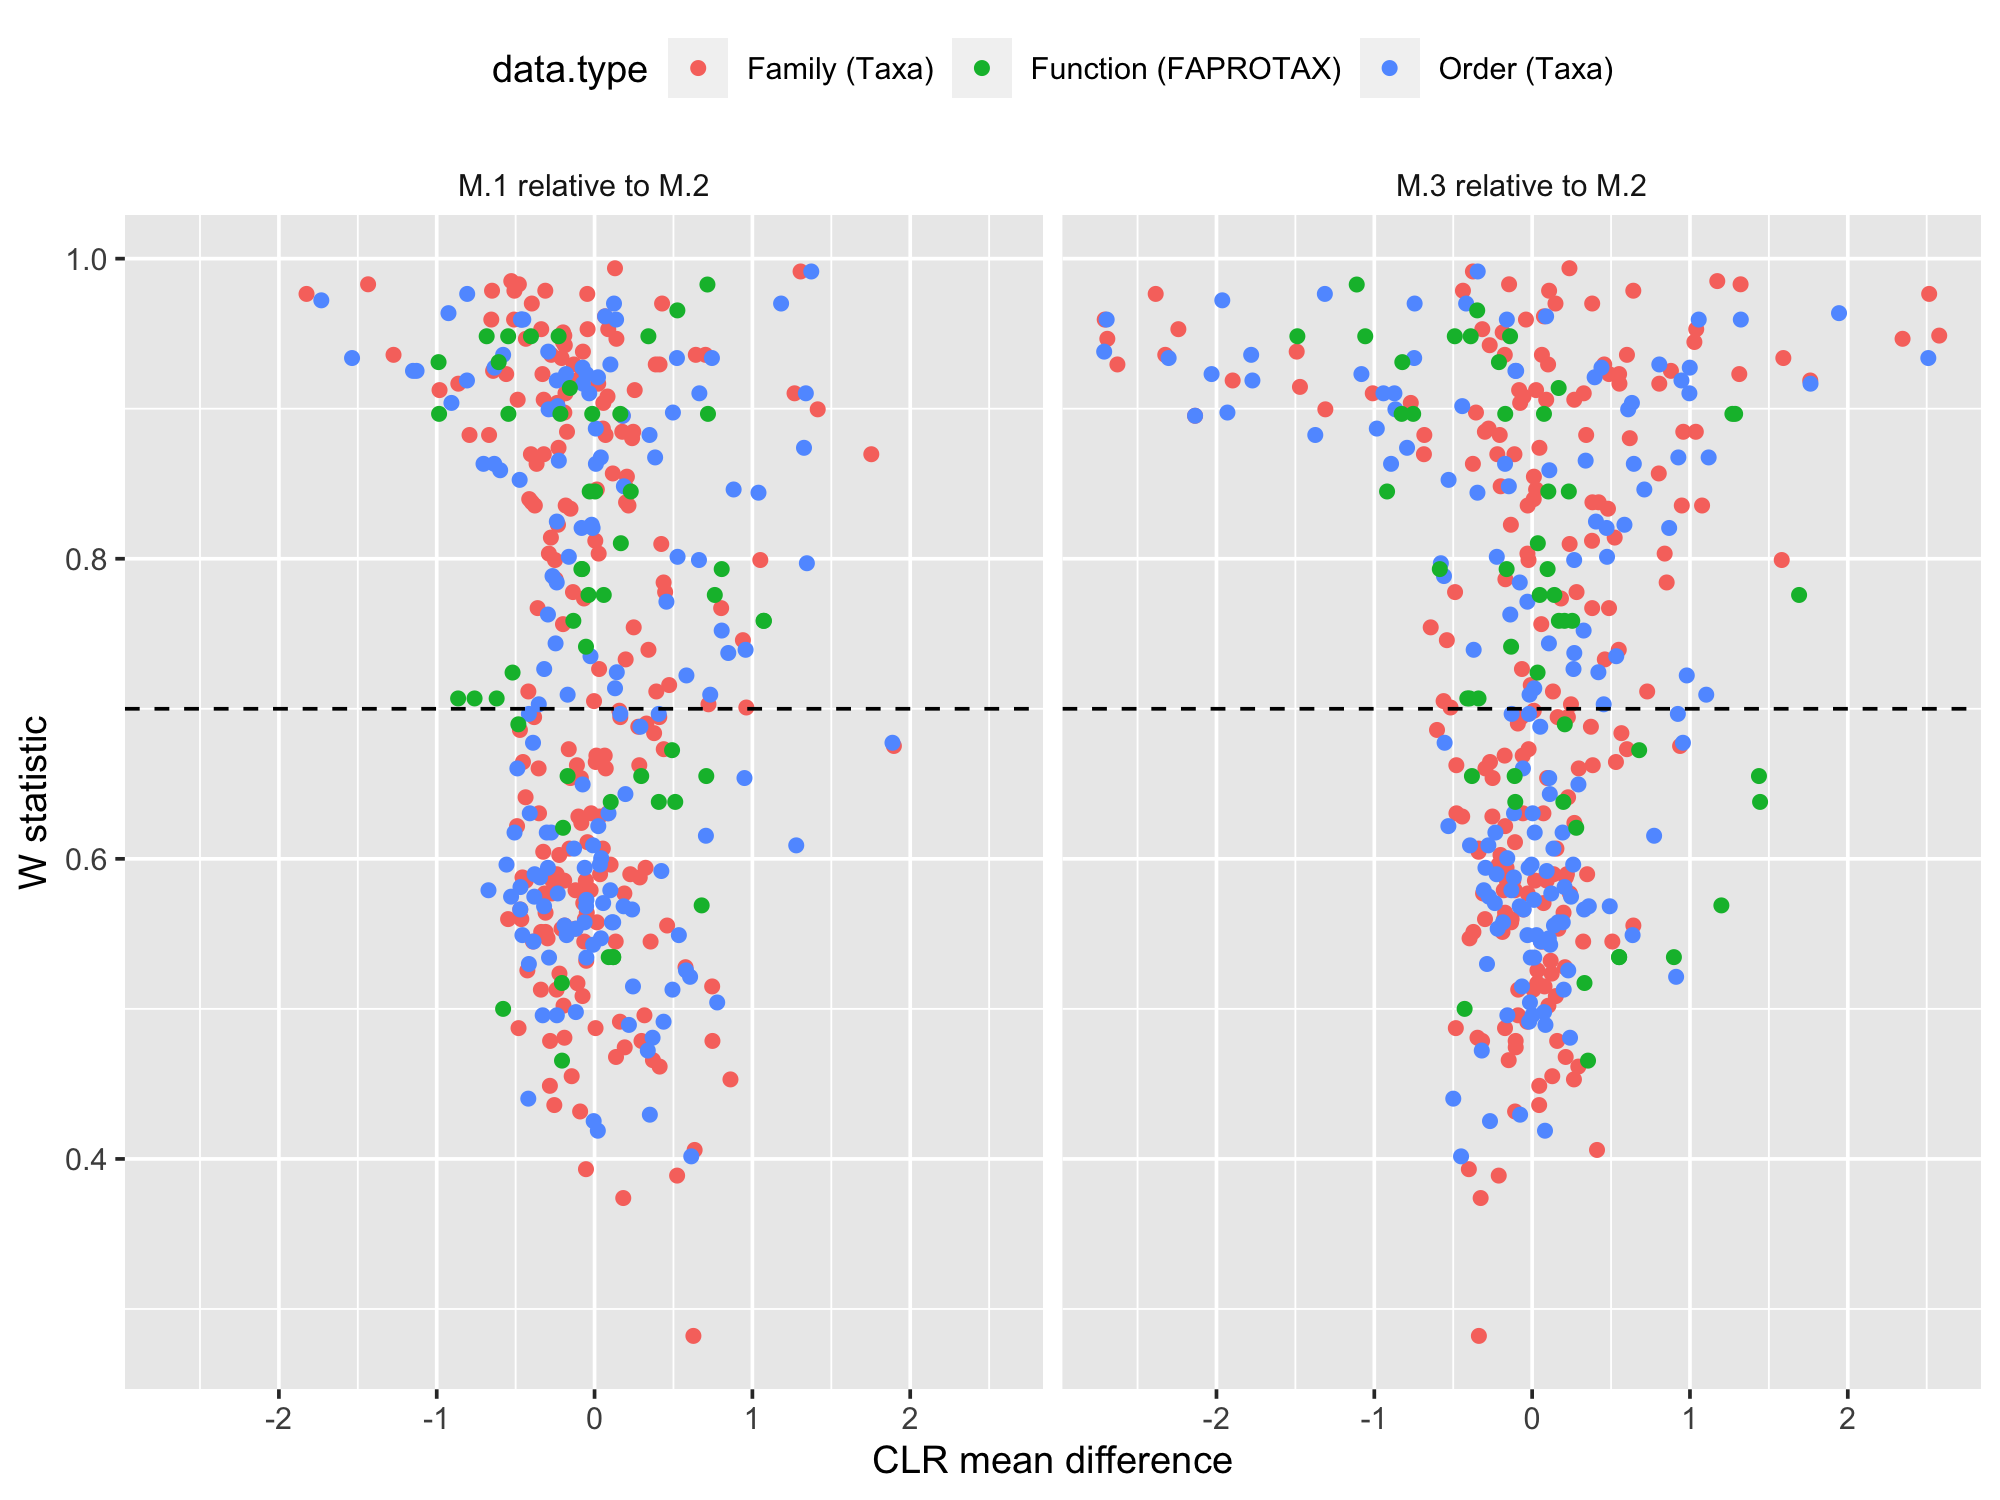

In [62]:
eff_size.f = res.f[['fig.data']][which(!(is.na(res.f[['fig.data']]$y))),]
eff_size.t = res.t[['fig.data']][which(!(is.na(res.t[['fig.data']]$y))),]
eff_size.f$y = (eff_size.f$y)/(nrow(prepro.f$feature_table))
eff_size.t$y = (eff_size.t$y)/(nrow(prepro.t$feature_table))
eff_size = rbind(eff_size.t, eff_size.f)
eff_size[which(eff_size$group == 'Microbial.Clusters2 = M.3'),'group'] = 'M.3 relative to M.2'
eff_size[which(eff_size$group == 'Microbial.Clusters2 = M.1'),'group'] = 'M.1 relative to M.2'
eff_size[,'data.type'] = NA
eff_size[which(eff_size$taxa_id %in% rownames(taxa_abund)), 'data.type'] = 'Family (Taxa)'
eff_size[which(eff_size$taxa_id %in% rownames(fxn_abund)), 'data.type'] = 'Function (FAPROTAX)'
eff_size[which(eff_size$taxa_id %in% rownames(taxa_abund2)), 'data.type'] = 'Order (Taxa)'
eff_size$data.type <- factor(eff_size$data.type)
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res = 250)
fig = ggplot(data = eff_size) + aes(x = x, y = y) + 
      geom_point(aes(color = data.type)) + facet_wrap(~ group) +
      labs(x = "CLR mean difference", y = "W statistic") +
      theme(plot.title = element_text(hjust = 0.5), legend.position = "top",
            strip.background = element_rect(fill = "white")) + 
      geom_hline(yintercept = 0.7, linetype = "dashed") #+ 
#      geom_vline(xintercept = c(-1.25, 1.25) , linetype = "dashed")
fig

eff_size[which(eff_size$data.type == 'Function (FAPROTAX)'), ]

In [66]:
extra_fxn = c('aerobic_chemoheterotrophy', 'anoxygenic_photoautotrophy_S_oxidizing', 'hydrocarbon_degradation')
fxnThresh = which((eff_size$y > 0.75) & (abs(eff_size$x) > 1) & (eff_size$data.type == 'Function (FAPROTAX)'))
paste("Functions retained: ", length(unique(eff_size[fxnThresh, 'taxa_id'])), sep="")
taxnThresh = which((eff_size$y > 0.75) & (abs(eff_size$x) > 1) & (eff_size$data.type != 'Function (FAPROTAX)'))
paste("Taxa retained: ", length(unique(eff_size[taxnThresh, 'taxa_id'])), sep="")
eff_effprex = eff_size[union(fxnThresh, taxnThresh),]
eff_effpre = eff_effprex[which(!(eff_effprex$taxa_id %in% extra_fxn)),]
eff_effs = unique(subset(eff_effpre, select=c(-group, -x)))
sig_orders = eff_effs[which(eff_effs$data.type == 'Order (Taxa)'), 'taxa_id']
order_names = str_split_fixed(sig_orders, fixed('.'), n=2)[,2]
sig_fams = eff_effs[which(eff_effs$data.type == 'Family (Taxa)'), 'taxa_id']
order_names2 = str_split_fixed(sig_fams, fixed('.'), n=2)[,1]
order_overlap = sig_orders[which(order_names %in% order_names2)]
eff_effs = eff_effs[which(!(eff_effs$taxa_id %in% order_overlap)),]
nrow(eff_effs)
agg_abunds2 = rbind.data.frame(taxa_abund, fxn_abund, taxa_abund2)[eff_effs$taxa_id,]
agg_abunds2 = agg_abunds2/rowMeans(agg_abunds2)
agg_abunds2[1:5, 1:5]

# get aggregate abundances per cluster level
for (lev in levels(ENV.mini.ancom$Microbial.Clusters)){
    samps_i = ENV.mini.ancom[which(ENV.mini.ancom[,'Microbial.Clusters'] == lev), 'Sample.ID']
    aggd_abunds_i = rowMeans(agg_abunds2[, samps_i])
    newName = as.character(lev)
    eff_effs = cbind.data.frame(eff_effs, data.frame(newName = aggd_abunds_i))
    colnames(eff_effs)[colnames(eff_effs) == 'newName'] = newName
}

eff_effs[order(eff_effs$data.type, eff_effs$y),]
min(apply(eff_effs[,4:6], 1, max))

[1] "Functions retained: 8"

[1] "Taxa retained: 55"

[1] 43

,SB071116TAWCSCB22D11BR2TR2I616,SB071116TAWCSCB74D13BR2TR1I173,SB071116TAWCSCB64D10BR1TR1I165,SB071116TAWCSCB72D20BR1TR1I169,SB071116TAWCSCB63D10BR2TR1I164
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
anoxygenic_photoautotrophy,0.006707686,1.1447031,0.4204237,0.5871110,0.4158514
aliphatic_non_methane_hydrocarbon_degradation,0.350736391,0.3008804,1.1194721,0.8265392,1.3967039
chloroplasts,2.027545595,1.1723634,1.4717050,1.5863352,0.5183088
photoautotrophy,1.118052195,0.5433119,1.0334755,0.6579568,1.1643547
chemoheterotrophy,0.918332721,1.2083307,1.0231274,1.1158952,1.1573715


,taxa_id,y,zero_ind,data.type,M.1,M.2,M.3
,<chr>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
3,Betaproteobacteriales.Burkholderiaceae,0.7991453,No,Family (Taxa),1.1081624,0.4334370,2.115855966
529,Thalassobaculales.Thalassobaculaceae,0.8354701,No,Family (Taxa),0.6610639,0.8308005,1.850062965
6,Chromatiales.Sedimenticolaceae,0.8696581,No,Family (Taxa),3.0592730,0.1496268,0.034003186
477,Flavobacteriales.Flavobacteriaceae,0.8846154,No,Family (Taxa),0.6014203,0.9399579,1.689097236
476,Synechococcales.Cyanobiaceae,0.8952991,No,Family (Taxa),1.2204009,1.2419279,0.152387413
22,Microtrichales.Ilumatobacteraceae,0.8995726,No,Family (Taxa),2.1061345,0.6752129,0.186081990
69,Solirubrobacterales.67.14,0.9102564,No,Family (Taxa),1.9883270,0.7469269,0.189786628
633,Planctomycetales.Gimesiaceae,0.9145299,No,Family (Taxa),0.9031916,1.3686264,0.310784024
527,Micrococcales.Microbacteriaceae,0.9188034,No,Family (Taxa),0.4779151,0.7106916,2.373513446


[1] "Family (Taxa)"

In [67]:
aerobic_proc = c('aerobic_ammonia_oxidation', 'aerobic_anoxygenic_phototrophy', 'aerobic_chemoheterotrophy', 
                 'aerobic_nitrite_oxidation', 'knallgas_bacteria', 'nitrification', 'oxygenic_photoautotrophy')

anaerobic_proc = c("acetoclastic_methanogenesis", "anammox", "arsenate_respiration", "dark_sulfite_oxidation", 
                   "denitrification", "fermentation", "fumarate_respiration", "hydrogenotrophic_methanogenesis", 
                   "iron_respiration", "manganese_respiration", "methanogenesis", 
                   "methanogenesis_by_CO2_reduction_with_H2", "methanogenesis_by_disproportionation_of_methyl_groups",
                   "methanogenesis_by_reduction_of_methyl_compounds_with_H2", "methanogenesis_using_formate", 
                   "nitrate_ammonification", "nitrate_denitrification", "nitrate_respiration", 
                   "nitrite_ammonification", "nitrite_denitrification", "nitrite_respiration", 
                   "nitrogen_respiration", "nitrous_oxide_denitrification", "reductive_acetogenesis", 
                   "respiration_of_sulfur_compounds", 'sulfate_respiration', "sulfite_respiration", 
                   'sulfur_respiration', "thiosulfate_respiration")

,y,data.type,population.id,community.cluster,mean.scaled.relative.abundance,O2.Status
,<dbl>,<fct>,<chr>,<fct>,<dbl>,<fct>
1,0.7586207,Function (FAPROTAX),anoxygenic_photoautotrophy,M.1,2.6591312,NA
2,0.9482759,Function (FAPROTAX),aliphatic_non_methane_hydrocarbon_degradation,M.1,0.9279247,NA
3,0.7758621,Function (FAPROTAX),chloroplasts,M.1,0.7908831,NA
4,0.9827586,Function (FAPROTAX),photoautotrophy,M.1,1.5060330,NA
5,0.8965517,Function (FAPROTAX),chemoheterotrophy,M.1,0.7374719,NA
6,0.9764957,Family (Taxa),Actinomarinales.Actinomarinaceae,M.1,0.5585179,NA


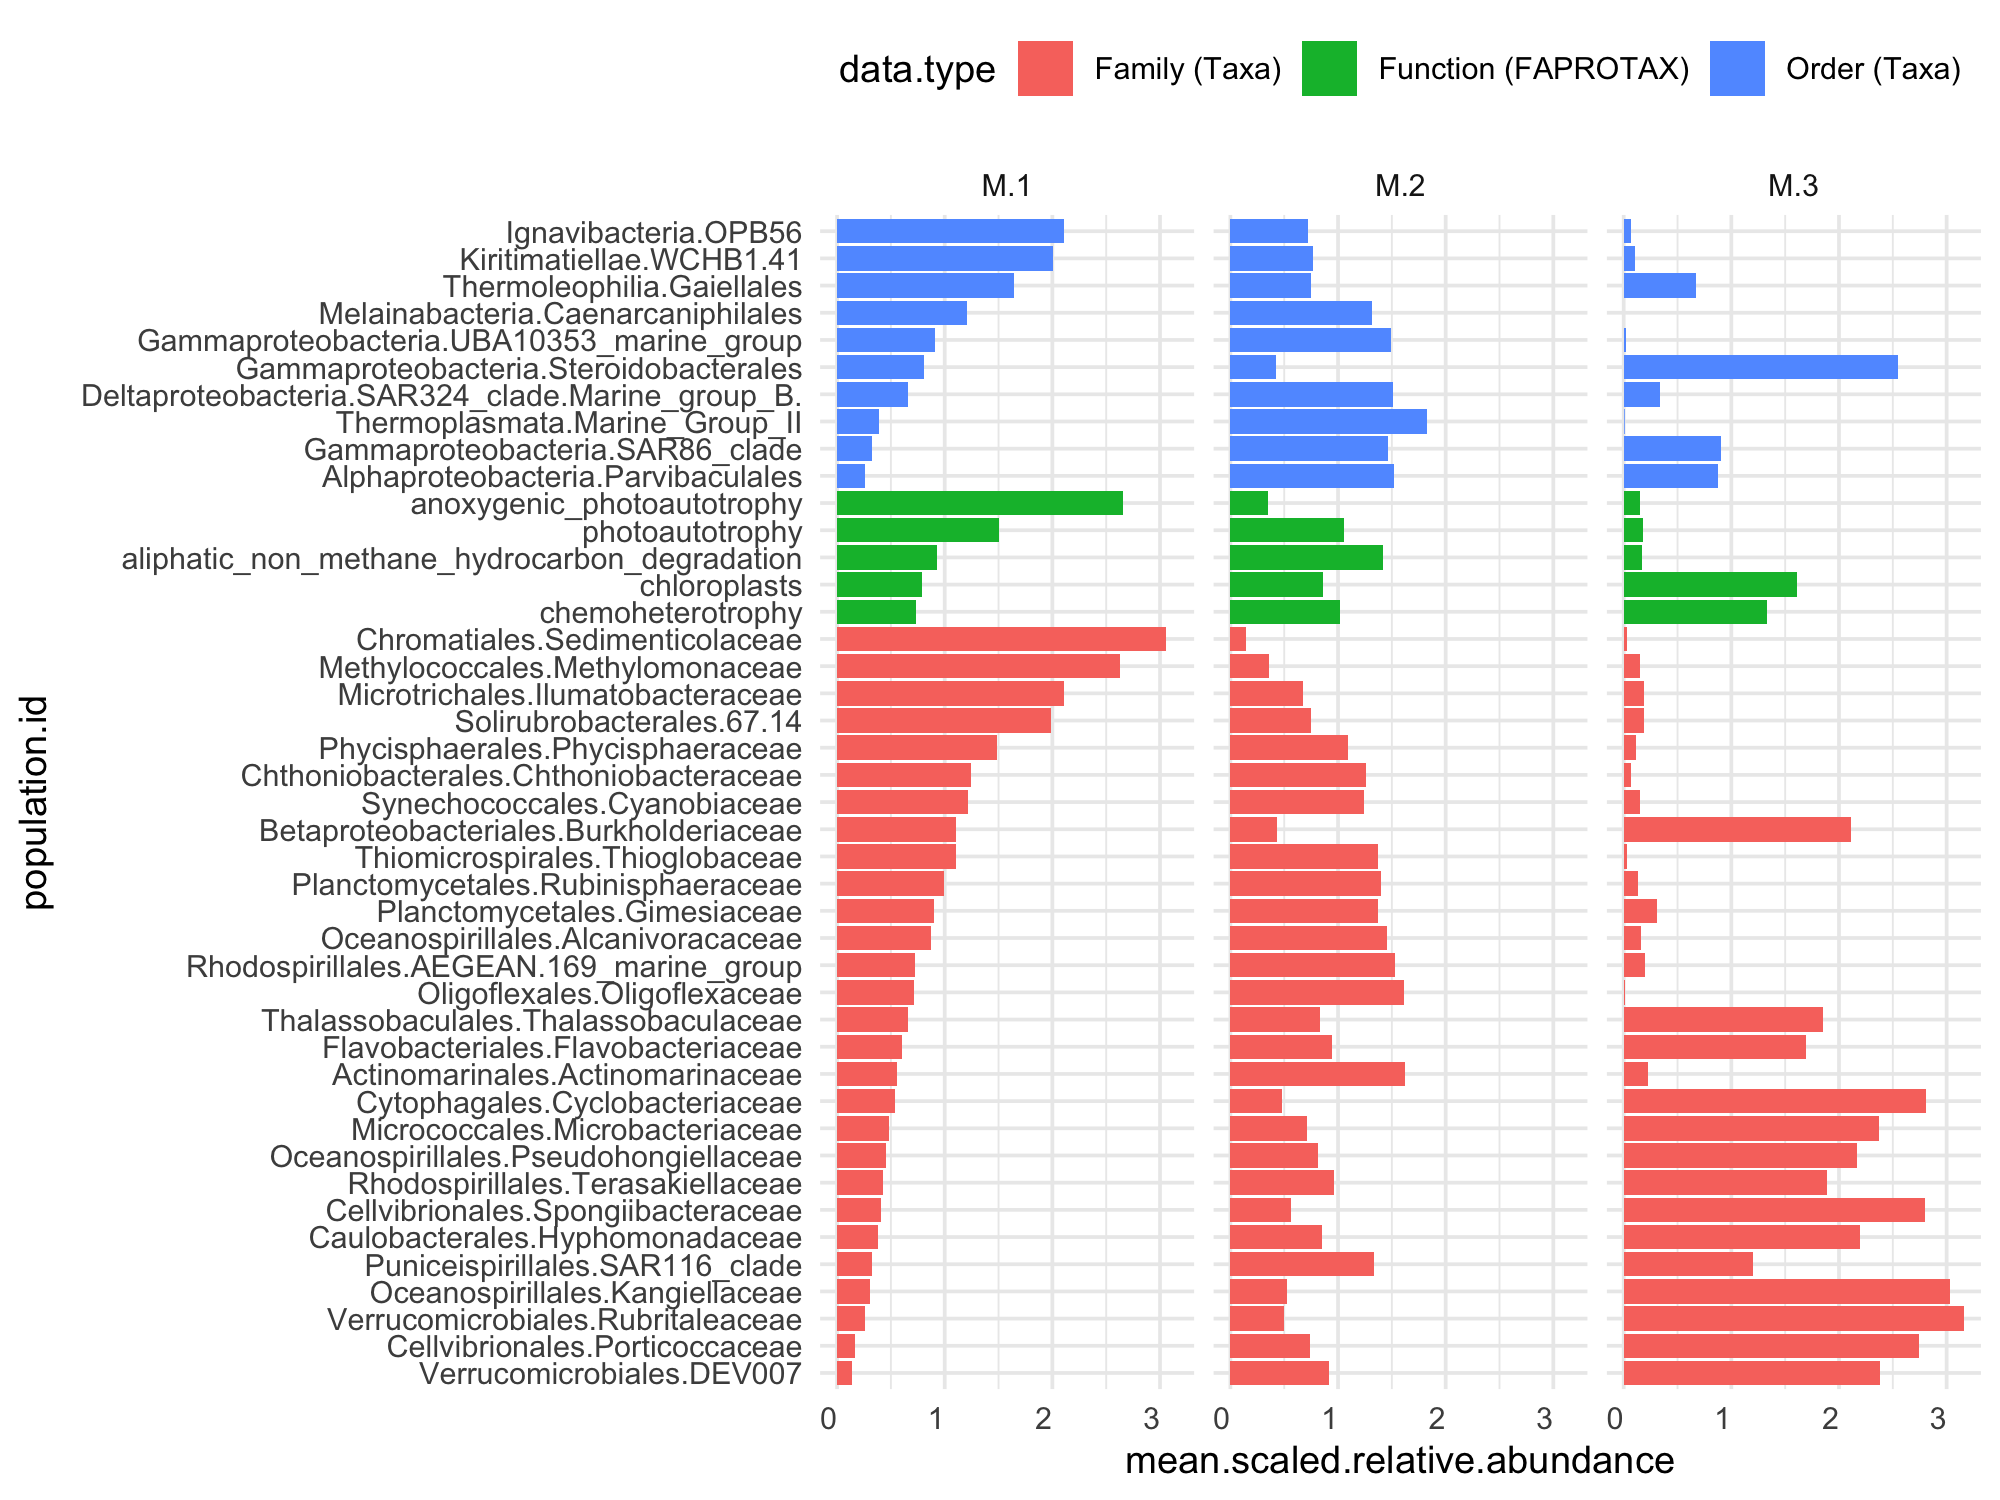

In [68]:
library(dplyr)
library(reshape2)
fxn_sum = cbind(eff_effs)

colnames(fxn_sum)[which(colnames(fxn_sum)== 'taxa_id')] <- 'population.id'
fxn_sum <- melt(fxn_sum, id.vars=c('y', 'data.type','population.id'), measure.vars=c('M.1', 'M.2', 'M.3'),  
                value.name='mean.scaled.relative.abundance', variable.name='community.cluster')
fxn_sum[,'O2.Status'] <- NA
fxn_sum[which(fxn_sum$population.id %in% aerobic_proc),'O2.Status'] = 'Aerobic'
fxn_sum[which(fxn_sum$population.id %in% anaerobic_proc),'O2.Status'] = 'Anaerobic'
fxn_sum[,'O2.Status'] <- factor(fxn_sum[,'O2.Status'])
fxn_sum[,'data.type'] <- factor(fxn_sum[,'data.type'])
head(fxn_sum)
fxn_sum = fxn_sum[order(fxn_sum[,'data.type'], fxn_sum[,'community.cluster'], fxn_sum[,'mean.scaled.relative.abundance']),]
fxn_sum$population.id <- factor(fxn_sum$population.id, levels=unique(as.character(fxn_sum$population.id)))

options(repr.plot.width=8, repr.plot.height=6)
p <-ggplot(fxn_sum, aes(x=population.id, y=mean.scaled.relative.abundance, fill=data.type)) + 
    geom_bar(stat="identity") + theme_minimal() + coord_flip() + 
    #scale_y_continuous(labels = function(x) {format(x, scientific = TRUE)}) + 
    theme(axis.text.x = element_text(angle = 0, vjust = 0.9, hjust=1))
                       
p + facet_grid(. ~ community.cluster) + theme(legend.position = "top")

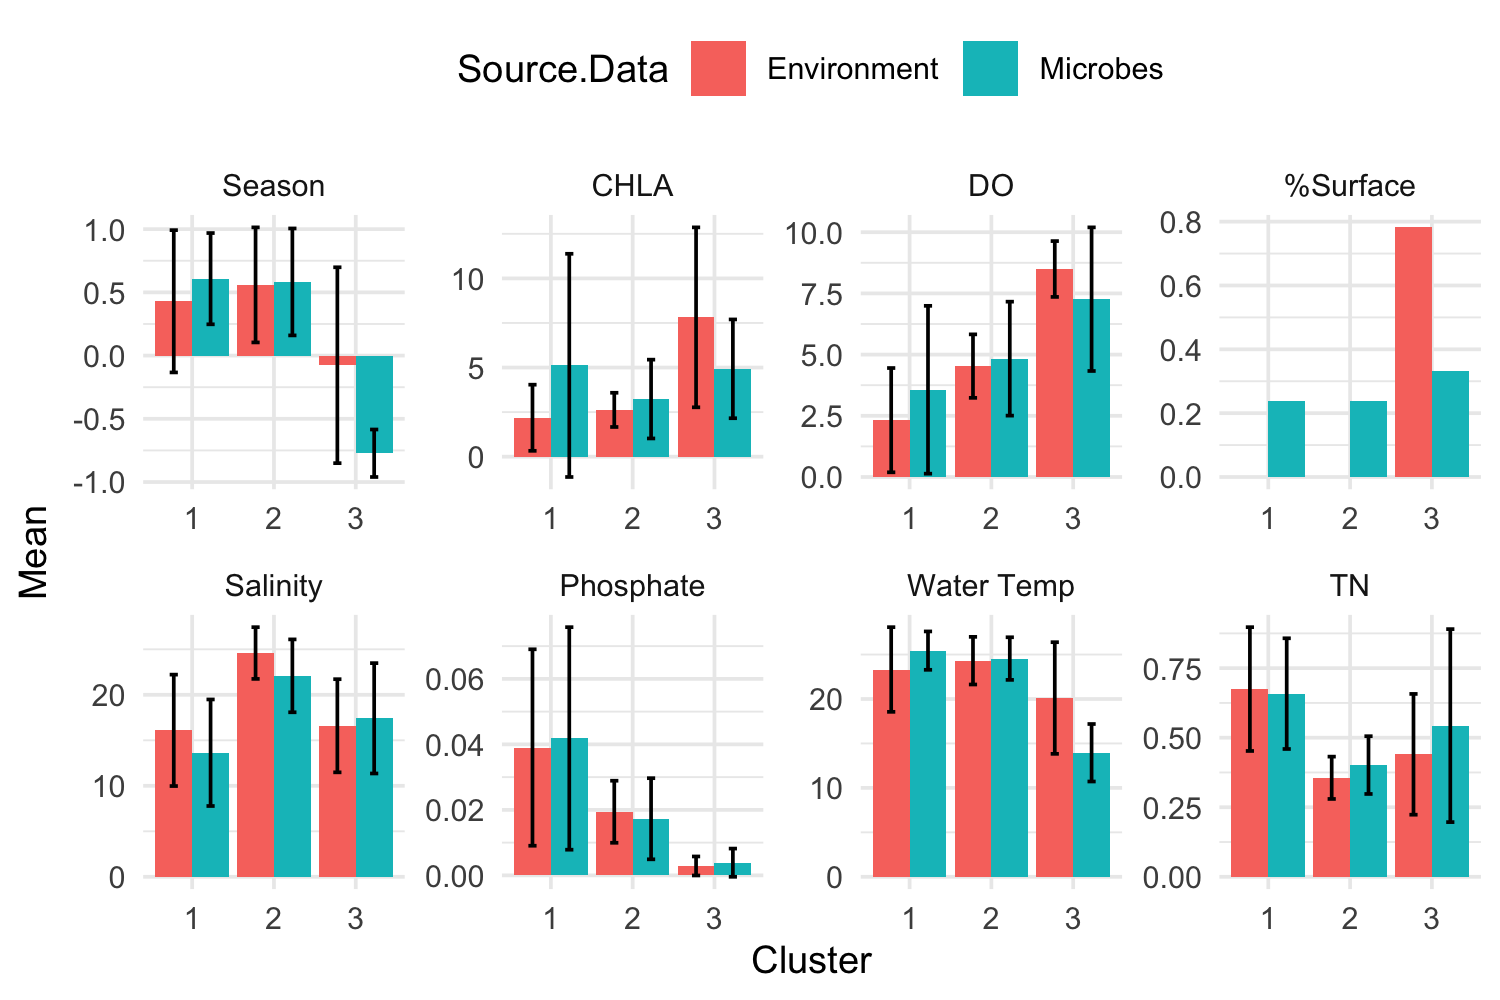

In [43]:
library(reshape2)
ENV.mini.manova = cbind(env_data_orig[,c('WaterColumnPosition', 'FallPeak', 'TN',
                                         'CHLA', 'PO4F', 'DO', 'WTEMP', 'SALINITY')])
colnames(ENV.mini.manova)[colnames(ENV.mini.manova) == 'FallPeak'] = 'Season'
colnames(ENV.mini.manova)[colnames(ENV.mini.manova) == 'SALINITY'] = 'Salinity'
ENV.mini.manova[,'PctSurface'] <- as.integer(factor(ENV.mini.manova[,'WaterColumnPosition'])) - 1
ENV.mini.manova[,'WaterColumnPosition'] <- NULL
num_cols = c('DO', 'WTEMP', 'Salinity', 'CHLA', 'PO4F', 'Season', 'TN')
ENV.by.level =  list()
ENV.by.level.sd =  list()
for (lev in levels(ENV.mini.ancom$Microbial.Clusters)){
    samps_i = rownames(ENV.mini.ancom)[which(ENV.mini.ancom[,'Microbial.Clusters'] == lev)]
    aggd_abunds_i = colMeans(ENV.mini.manova[samps_i,], na.rm=T)
    ENV.by.level[[lev]] = aggd_abunds_i
    ENV.by.level.sd[[lev]] = apply(ENV.mini.manova[samps_i,], 2, function(x) {sd(x, na.rm=T)})
}
env_by_mclust = data.frame(ENV.by.level)
env_by_mclust[,'Variables'] <- factor(rownames(env_by_mclust))
env_by_mclust.sd = data.frame(ENV.by.level.sd)
env_by_mclust.sd[,'Variables'] <- factor(rownames(env_by_mclust.sd))

env_by_mclust = cbind.data.frame(melt(env_by_mclust, id.vars='Variables', value.name='Mean'), 
                      data.frame('SD'=melt(env_by_mclust.sd, id.vars='Variables', value.name='SD')[,'SD']), 
                      data.frame('Source.Data'=rep('Microbes', nrow(env_by_mclust)*(ncol(env_by_mclust)-1))))

env_by_mclust$Cluster = factor(as.integer(env_by_mclust$variable))
ENV.mini.2[,'PctSurface'] <- as.integer(ENV.mini.2[,'WaterColumnPosition']) - 1
ENV.by.cclust =  list()
ENV.by.cclust.sd =  list()
for (lev in levels(ENV.mini.ancom$Habitat.Clusters)){
    samps_i = rownames(ENV.mini.ancom)[which(ENV.mini.ancom$Habitat.Clusters == lev)]
    aggd_abunds_i = colMeans(ENV.mini.manova[samps_i,], na.rm=T)
    ENV.by.cclust[[lev]] = aggd_abunds_i
    ENV.by.cclust.sd[[lev]] = apply(ENV.mini.manova[samps_i,], 2, function(x) {sd(x, na.rm=T)})
}

env_by_cclust = data.frame(ENV.by.cclust)
env_by_cclust[,'Variables'] <- factor(rownames(env_by_cclust))
env_by_cclust = cbind.data.frame(melt(env_by_cclust, id.vars='Variables', value.name='Mean'), 
                                 data.frame('SD'=melt(ENV.by.cclust.sd, id.vars='Variables', value.name='SD')[,'SD']), 
                                 data.frame('Source.Data'=rep('Environment', 
                                                               nrow(env_by_cclust)*(ncol(env_by_cclust)-1))))
env_by_cclust$Cluster = factor(as.integer(env_by_cclust$variable))

env_by_clust = rbind.data.frame(env_by_cclust, env_by_mclust)

env_by_clust[which(env_by_clust$Variables == 'PctSurface'), 'SD'] <- NA
levels(env_by_clust$Variables) <- list('Season'="Season", 'CHLA'="CHLA", 'DO'='DO',
                                       '%Surface'="PctSurface", 'Salinity'='Salinity', 
                                       'Phosphate'='PO4F', 'Water Temp'='WTEMP', 'TN'='Total Nitrogen')

options(repr.plot.width=6, repr.plot.height=4)
p <-ggplot(env_by_clust, aes(x=Cluster, y=Mean, fill=Source.Data)) + 
    geom_bar(stat="identity", position=position_dodge()) + theme_minimal() +
    geom_errorbar(aes(ymin=Mean-SD, ymax=Mean+SD), width=.2,
                   position=position_dodge(.9)) #+
     #theme(aspect.ratio = 1, strip.background = element_blank(), strip.placement = "outside")
    #theme(strip.text.y.right = element_text(angle = 0))
     #+ coord_flip()# + 
    #scale_y_continuous(labels = function(x) {format(x, scientific = TRUE)}) + 
    #theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
                       
p <- p + facet_wrap(Variables ~ ., scales='free', strip.position='top', nrow=2)
p + theme(legend.position = "top")


In [ ]:
options(repr.plot.width=8, repr.plot.height=4)
subagg_abunds = rbind.data.frame(taxa_abund, fxn_abund, taxa_abund2)
subagg_pa = (subagg_abunds > 0) * 1
site_occupancy = (rowSums(subagg_pa) / max(rowSums(subagg_pa)))*100
par(mfrow=c(1,2))
hist(site_occupancy, breaks=seq(0, 100, 2), main='',
     ylab='# Orders, Families, or Functions', xlab='Percent of Samples Occupied')
abline(v=(222/236)*100, col='red')

coreMicro = names(site_occupancy)[which(site_occupancy > ((222/236)*100))]
coreFxn = coreMicro[which(coreMicro %in% rownames(fxn_abund))]
fxnStd = apply(t(fxn_abund[coreFxn,])/1e+6, 2, function(x) {sd(x)/mean(x)})
fxnInvariant = names(fxnStd)[which(fxnStd < 0.85)]
length(fxnInvariant)

subagg_abunds2 = rbind.data.frame(taxa_abund, taxa_abund2)
coreTax = coreMicro[which(coreMicro %in% rownames(subagg_abunds2))]
fxnTax = apply(t(subagg_abunds2[coreTax,])/1e+6, 2, function(x) {sd(x)/mean(x)})
taxInvariant = names(fxnTax)[which(fxnTax < 0.85)]
length(taxInvariant)

hist(c(fxnStd, fxnTax), breaks=50, main='',
     ylab='# Orders, Families, or Functions', xlab='Coeff. of Variation in Abundances')
abline(v=0.85, col='red')

coreMicro = union(taxInvariant, fxnInvariant)

In [ ]:
core_abunds = data.frame(matrix(NA, nrow=length(coreMicro), 
                                ncol= length(levels(ENV.mini.ancom[,'Microbial.Clusters'])),
                                dimnames=list(coreMicro, levels(ENV.mini.ancom[,'Microbial.Clusters']))))

for (lev in levels(ENV.mini.ancom[,'Microbial.Clusters'])){
    samps_i = ENV.mini.ancom[which(ENV.mini.ancom[,'Microbial.Clusters'] == lev), 'Sample.ID']
    aggd_abunds_i = rowMeans(subagg_abunds[rownames(core_abunds), samps_i]) 
    aggd_abunds_i = aggd_abunds_i/ rowMeans(subagg_abunds[rownames(core_abunds),])
    newName = as.character(lev)
    core_abunds[, lev] = aggd_abunds_i[rownames(core_abunds)]
}

core_abunds2 = cbind(core_abunds, str_split_fixed(rownames(core_abunds), fixed('.'), n=2))
colnames(core_abunds2) <- c(colnames(core_abunds), 'Name1', 'Name2')
core_abunds = core_abunds[which(!(core_abunds2$Name2 %in% unique(core_abunds2$Name1))),]
core_abunds = core_abunds[which(!(rownames(core_abunds) %in% eff_effprex$taxa_id)),]
dim(core_abunds)

core_abunds[,'data.type'] <- NA
core_abunds[which(rownames(core_abunds) %in% rownames(taxa_abund)), 'data.type'] = 'Family'
core_abunds[which(rownames(core_abunds) %in% rownames(fxn_abund)), 'data.type'] = 'Function'
core_abunds[which(rownames(core_abunds) %in% rownames(taxa_abund2)), 'data.type'] = 'Order'

core_sum = cbind(core_abunds)
core_sum[, 'population.id'] <- rownames(core_sum)
core_sum <- melt(core_sum, id.vars=c('data.type','population.id'), measure.vars=c('M.1', 'M.2', 'M.3'),  
                value.name='relative.abundance', variable.name='community.cluster')
core_sum[,'O2.Status'] <- NA
core_sum[which(core_sum$population.id %in% aerobic_proc),'O2.Status'] = 'Aerobic'
core_sum[which(core_sum$population.id %in% anaerobic_proc),'O2.Status'] = 'Anaerobic'
core_sum[,'O2.Status'] <- factor(core_sum[,'O2.Status'])
core_sum[,'data.type'] <- factor(core_sum[,'data.type'])
core_sum = core_sum[order(core_sum$data.type),]
core_sum$population.id <- factor(core_sum$population.id, levels=unique(as.character(core_sum$population.id)))

options(repr.plot.width=8, repr.plot.height=5)
p <-ggplot(core_sum, aes(x=population.id, y=relative.abundance, fill=data.type)) + 
    geom_bar(stat="identity") + theme_minimal() + coord_flip() + 
#    scale_y_continuous(labels = function(x) {format(x, scientific = TRUE)}) + 
    theme(axis.text.x = element_text(angle = 0, vjust = 0.9, hjust=1))
                       
p + facet_grid(. ~ community.cluster) + theme(legend.position = "top")

In [ ]:
fap_df = t(read.delim('../data/faprotax_data/report_silva.2.txt', sep="\t", comment.char = '#', row.names=1))
unrar_df = read.delim('../data/otu_tables/final_unrarefied_table.2.txt', sep="\t", row.names=1)
taxa_df = read.delim('../data/otu_tables/taxa_table_with_OTUs.txt', sep="\t", row.names=1)

In [ ]:
m1fxn = c('human_pathogens_all', 'aliphatic_non_methane_hydrocarbon_degradation', 'photoautotrophy')

surf_samps = rownames(md_i[which(md_i$mclusts2 %in% c('M.1')),])
afxn = m1fxn[2]
spec_fap = fap_df[afxn,]
spec_fap = spec_fap[which(spec_fap > 0)]

topset = colMeans(unrar_df[surf_samps, names(spec_fap)]/ rowSums(unrar_df[surf_samps,])) 
topset = topset[which(topset > 0)]
pop_names = cbind.data.frame(taxa_df[names(topset),], topset)

pop_names[,'pop_id'] = paste(pop_names[,5], pop_names[,6], pop_names[,7], sep=".")
pop_agg = aggregate(topset ~ pop_id, data=pop_names, sum)
pop_agg = cbind.data.frame(pop_agg[order(pop_agg$pop_id), ])#, list('fxn' = rep(afxn, length(pop_agg))))

pop_agg[,'topset'] = round((pop_agg[,'topset'])*100, 4)
#sum(pop_agg[,'topset'])
#pop_agg[,]

m1taxa = c('Rubritaleaceae', 'Cyclobacteriaceae', 'Microbacteriaceae', 'Hyphomonadaceae')
taxa_pops = list()
for(a_tax in m1taxa){
    orders_i = unique(taxa_df[grep(a_tax, taxa_df[,'Family']),'Order'])
    taxa_pops[[a_tax]] = rownames(taxa_df[which(taxa_df[,'Order'] %in% orders_i),])
}
#taxa_pops
for(x in m1taxa){
    present_pops = taxa_pops[[x]][which(taxa_pops[[x]] %in% colnames(unrar_df))]
    present_abund = colMeans(unrar_df[surf_samps, present_pops]/rowSums(unrar_df[surf_samps,]))
    taxa_pops[[paste(x, 'sum', sep=".")]] = round(sum(present_abund)*100, 3)
    taxa_pops[[x]] = sum(present_abund > 0)
    present_abund = present_abund[which(present_abund > 0)]
    pop_names2 = cbind.data.frame(taxa_df[names(present_abund),], present_abund)
    pop_names2[,'pop_id'] = paste(pop_names2[,5], pop_names2[,6], pop_names2[,7], sep=".")
    pop_agg2 = aggregate(present_abund ~ pop_id, data=pop_names2, sum)
    pop_agg2 = cbind.data.frame(pop_agg2[order(pop_agg2$pop_id), ])
    pop_agg2$present_abund = round(pop_agg2$present_abund*100, 4)
    taxa_pops[[paste(x, 'tax', sep=".")]] = pop_agg2
}
taxa_pops



In [ ]:
freshet = rownames(plot.df.mini[which(plot.df.mini$Microbial.Clusters == 'M.2'),])
allfxns = c('nitrogen_fixation', 'aromatic_hydrocarbon_degradation', 'nitrite_respiration')
afxn = allfxns[2]
spec_fap = fap_df[afxn,]
spec_fap = spec_fap[which(spec_fap > 0)]

topset = colMeans(unrar_df[freshet, names(spec_fap)] / rowSums(unrar_df[freshet,])) 
topset = topset[which(topset > 0)]
pop_names = cbind.data.frame(taxa_df[names(topset),], topset)

pop_names[,'pop_id'] = paste(pop_names[,4], pop_names[,5], pop_names[,6], pop_names[,7], sep=".")
pop_agg = aggregate(topset ~ pop_id, data=pop_names, sum)
pop_agg = cbind.data.frame(pop_agg[order(pop_agg$pop_id), ])#, list('fxn' = rep(afxn, length(pop_agg))))

pop_agg[,'topset'] = round((pop_agg[,'topset'])*100, 4)
#sum(pop_agg[,'topset'])
#pop_agg


m1taxa = c('Arenicellaceae', 'Clade_IV', 'Kangiellaceae', 'Rubritaleaceae')
taxa_pops = list()
for(a_tax in m1taxa){taxa_pops[[a_tax]] = rownames(taxa_df[grep(a_tax, taxa_df[,'Family']),])}
#taxa_pops
for(x in m1taxa){
    present_pops = taxa_pops[[x]][which(taxa_pops[[x]] %in% colnames(unrar_df))]
    present_abund = colMeans(unrar_df[freshet, present_pops]/rowSums(unrar_df[freshet,]))
    taxa_pops[[paste(x, 'sum', sep=".")]] = round(sum(present_abund)*100, 3)
    taxa_pops[[x]] = sum(present_abund > 0)
    present_abund = present_abund[which(present_abund > 0)]
    pop_names2 = cbind.data.frame(taxa_df[names(present_abund),], present_abund)
    pop_names2[,'pop_id'] = paste(pop_names2[,5], pop_names2[,6], pop_names2[,7], sep=".")
    pop_agg2 = aggregate(present_abund ~ pop_id, data=pop_names2, sum)
    pop_agg2 = cbind.data.frame(pop_agg2[order(pop_agg2$pop_id), ])
    pop_agg2$present_abund = round(pop_agg2$present_abund*100, 4)
    taxa_pops[[paste(x, 'tax', sep=".")]] = pop_agg2
}
#taxa_pops



In [ ]:
hypoxic = rownames(md_i[which(md_i$mclusts2 == 'M.3'),])
allfxns = c('dark_oxidation_of_sulfur_compounds', 'nitrate_respiration', 
            'sulfate_respiration', 'nitrate_reduction')
afxn = allfxns[4]
spec_fap = fap_df[afxn,]
spec_fap = spec_fap[which(spec_fap > 0)]

topset = colMeans(unrar_df[hypoxic, names(spec_fap)] / rowSums(unrar_df[hypoxic,])) 
topset = topset[which(topset > 0)]
pop_names = cbind.data.frame(taxa_df[names(topset),], topset)

pop_names[,'pop_id'] = paste(pop_names[,4], pop_names[,5], pop_names[,6], pop_names[,7], sep=".")
pop_agg = aggregate(topset ~ pop_id, data=pop_names, sum)
pop_agg = cbind.data.frame(pop_agg[order(pop_agg$pop_id), ])#, list('fxn' = rep(afxn, length(pop_agg))))

pop_agg[,'topset'] = round((pop_agg[,'topset'])*100, 4)
sum(pop_agg[,'topset'])
pop_agg
cow

m1taxa = c('WCHB1.41', 'Chromatiales', 'Chlamydiales', 'Thioglobaceae', 'Ectothiorhodospiraceae', 'Gimesiaceae')
taxa_pops = list()
for(a_tax in m1taxa){
    fam_rows = grep(a_tax, taxa_df[,'Family'])
    if (length(fam_rows) == 0)
        fam_rows = grep(a_tax, taxa_df[,'Order'])
    taxa_pops[[a_tax]] = rownames(taxa_df[fam_rows,])
}
taxa_pops
for(x in m1taxa){
    present_pops = taxa_pops[[x]][which(taxa_pops[[x]] %in% colnames(unrar_df))]
    present_abund = colMeans(unrar_df[hypoxic, present_pops]/rowSums(unrar_df[hypoxic,]))
    taxa_pops[[paste(x, 'sum', sep=".")]] = round(sum(present_abund)*100, 3)
    taxa_pops[[x]] = sum(present_abund > 0)
    present_abund = present_abund[which(present_abund > 0)]
    pop_names2 = cbind.data.frame(taxa_df[names(present_abund),], present_abund)
    pop_names2[,'pop_id'] = paste(pop_names2[,5], pop_names2[,6], pop_names2[,7], sep=".")
    pop_agg2 = aggregate(present_abund ~ pop_id, data=pop_names2, sum)
    pop_agg2 = cbind.data.frame(pop_agg2[order(pop_agg2$pop_id), ])
    pop_agg2$present_abund = round(pop_agg2$present_abund*100, 4)
    taxa_pops[[paste(x, 'tax', sep=".")]] = pop_agg2
}
taxa_pops



In [ ]:
ENV.mini.manova = cbind(env_data_orig[,c('WaterColumnPosition', 'TN', 'CHLA', 'DO', 'WTEMP', 'SALINITY')])

ENV.mini.manova[,'PctSurface'] <- as.integer(factor(ENV.mini.manova[,'WaterColumnPosition'])) - 1
head(ENV.mini.manova)

In [ ]:
library(MASS)
library(sfsmisc)

rr.do <- rlm(DO*-1 ~ Latitude + WTEMP + WaterColumnPosition, data = comp_orig, maxit=200)

summary(rr.do)
f.robftest(rr.do, var = "Latitude")
f.robftest(rr.do, var = "WTEMP")
f.robftest(rr.do, var = "WaterColumnPositionupper")

options(repr.plot.width=6, repr.plot.height=6)
par(mfrow = c(2,2))

plot(comp_orig$Latitude, comp_orig$DO, xlab='Latitude', ylab='DO')
plot(comp_orig$Latitude, rr.do$residuals, xlab='Latitude', ylab='DO residuals')
plot(comp_orig$WTEMP, comp_orig$DO, xlab='WTEMP', ylab='DO')
plot(comp_orig$WTEMP, rr.do$residuals, xlab='WTEMP', ylab='DO residuals')


In [ ]:
rr.no2 <- rlm(NO2F ~ Latitude + FallPeak + WaterColumnPosition, data = comp_orig, maxit=200)

f.robftest(rr.no2, var = "Latitude")
f.robftest(rr.no2, var = "FallPeak")
f.robftest(rr.no2, var = "WaterColumnPositionupper")

options(repr.plot.width=6, repr.plot.height=6)
par(mfrow = c(2,2))
plot(comp_orig$Latitude, comp_orig$NO2F, xlab='Latitude', ylab='NO2F')
plot(comp_orig$Latitude, rr.no2$residuals, xlab='Latitude', ylab='NO2F residuals')
plot(comp_orig$FallPeak, comp_orig$NO2F, xlab='Seasonality', ylab='NO2F')
plot(comp_orig$FallPeak, rr.no2$residuals, xlab='Seasonality', ylab='NO2F')

In [ ]:
rr.po4 <- rlm(PO4F ~ Latitude*FallPeak + WaterColumnPosition, data = comp_orig, maxit=200)
summary(rr.po4)

f.robftest(rr.po4, var = "Latitude")
f.robftest(rr.po4, var = "FallPeak")
f.robftest(rr.po4, var = "Latitude:FallPeak")
f.robftest(rr.po4, var = "WaterColumnPositionupper")

options(repr.plot.width=6, repr.plot.height=6)
par(mfrow = c(2,2))
plot(comp_orig$Latitude, comp_orig$PO4F, xlab='Latitude', ylab='PO4F')
plot(comp_orig$Latitude, rr.po4$residuals, xlab='Latitude', ylab='PO4F residuals')
plot(comp_orig$FallPeak, comp_orig$PO4F, xlab='Seasonality', ylab='PO4F')
plot(comp_orig$FallPeak, rr.po4$residuals, xlab='Seasonality', ylab='PO4F residuals')

In [ ]:
resid_df = cbind(rr.no2$residuals, rr.po4$residuals, rr.do$residuals)
dim(resid_df)
dim(comp_orig)
rownames(resid_df) <- rownames(comp_orig)
colnames(resid_df) <- c('NO2F_residuals', 'PO4F_residuals',  'DO_residuals')
resid_df = as.data.frame(resid_df)

resid_file = paste(env_data_dir, 'environmental_residuals.txt', sep="/")
write.table(resid_df, file=resid_file, sep="\t")

In [ ]:
nti_fn = "../otu_data/dispersal_selection_data/ses_nti.RData"
load(nti_fn)
bnti_df = mntd_scores$comdistnt.obs.z[incl_samps, incl_samps]
bnti_dist = as.dist(bnti_df)

In [ ]:
ps.rarefied = rarefy_even_depth(ps, rngseed=1, sample.size=0.9*min(sample_sums(ps)), replace=F)

In [ ]:
BC.nmds.3D = metaMDS(OTU.clean2, distance="bray", k=3, trymax=1000)

In [ ]:
OTU.UF = otu_table(as.matrix(OTU.clean), taxa_are_rows=FALSE)
tax.UF = tax_table(as.matrix(tax.clean))
meta.UF = sample_data(meta)
wUF.dist = UniFrac(physeq.tree, weighted=TRUE, normalized=TRUE)
BC.nmds

In [ ]:
BC.nmds = metaMDS(OTU.clean, distance="bray", k=2, trymax=1000)
fit.BC = envfit(BC.nmds, meta[,c("AgeGroup", "ADGKG")])
fit.BC.OTU = envfit(BC.nmds, OTU.clean[,1:10])

In [ ]:
adonis(BC.dist ~ AgeGroup*ADGKG, data = meta, permutations = 1000)
adonis(uwUF.dist ~ AgeGroup*ADGKG, data=meta, permutations = 1000)
permutest(disp.age, pairwise=TRUE, permutations=1000)
simper(OTU.clean, meta$AgeGroup, permutations=100)
kruskal.test(OTU.clean$Otu00001 ~ meta$AgeGroup)
#Note: These P-values have not been corrected from false discovery rate (fdr) yet.



In [ ]:

KW.results = data.frame(read.csv("Age_krusk_simper.csv"))
#Remove non-significant
KW.results.signif = KW.results[KW.results$fdr_krusk_p.val < 0.05,]
#Order by OTU#
KW.results.signif = KW.results.signif[with(KW.results.signif, order(OTU)),]
head(KW.results.signif)